In [1]:
from fastai2.data.external import untar_data,URLs
from fastai2.data.transforms import get_image_files
from fastai2.vision.all import *
import PIL

In [43]:
path = Path()

In [3]:
untar_data(url='https://storage.googleapis.com/public_release/FEC_dataset.zip', dest='data')

Path('data/FEC_dataset')

In [4]:
path = Path()
train_csv = path/"data/FEC_dataset/faceexp-comparison-data-train-public.csv"
text = train_csv.readlines()
text[0]

'"http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg",0.142578,0.266602,0.065421,0.297508,"http://farm3.staticflickr.com/2127/5765052001_fa4c5fd8b0_b.jpg",0.439490,0.596178,0.289062,0.427734,"http://farm4.staticflickr.com/3747/8914150145_b9b336331c_b.jpg",0.345703,0.453125,0.075110,0.262150,ONE_CLASS_TRIPLET,269701,2,291701,2,321402,2,321501,2,321902,3,322102,2\n'

In [5]:
import pandas as pd
col_names = ['url1', 'top-left-col-1', 'bottom-right-col-1', 'top-left-row-1', 'bottom-right-row-1',
               'url2', 'top-left-col-2', 'bottom-right-col-2', 'top-left-row-2', 'bottom-right-row-2',
               'url3', 'top-left-col-3', 'bottom-right-col-3', 'top-left-row-3', 'bottom-right-row-3',
               'triplet-type', 'annotator1_id', 'annotation1', 'annotator2_id', 'annotation2', 'annotator3_id', 'annotation3',
                'annotator4_id', 'annotation4', 'annotator5_id', 'annotation5', 'annotator6_id', 'annotation6']

# uncomment to download only 10 images for tests
#img_df = pd.read_csv(str(train_csv), sep=",", quotechar='"', error_bad_lines=False, warn_bad_lines=True, names=col_names, nrows=10)
img_df = pd.read_csv(str(train_csv), sep=",", quotechar='"', error_bad_lines=False, warn_bad_lines=True, names=col_names)
len(img_df)

449143

In [7]:
img_df.head()

url1  \
0  http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg   
1  http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg   
2  http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg   
3  http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg   
4  http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg   

   top-left-col-1  bottom-right-col-1  top-left-row-1  bottom-right-row-1  \
0        0.142578            0.266602        0.065421            0.297508   
1        0.142578            0.266602        0.065421            0.297508   
2        0.142578            0.266602        0.065421            0.297508   
3        0.718750            0.826172        0.194704            0.394081   
4        0.718750            0.826172        0.194704            0.394081   

                                                              url2  \
0   http://farm3.staticflickr.com/2127/5765052001_fa4c5fd8b0_b.jpg   
1   http://farm4.staticflickr.com/3543/3387356856_1c35c2efdf_b.jpg   
2  http://farm4.staticflickr.com/3858/14540292875_ffb91ba2fb_b.jpg   
3  http://farm4.staticflickr.com/3875/14501588548_9ab31946e1_b.jpg   
4   http://farm6.staticflickr.com/5143/5693754914_661a07e85b_b.jpg   

   top-left-col-2  bottom-right-col-2  top-left-row-2  bottom-right-row-2  \
0        0.439490            0.596178        0.289062            0.427734   
1        0.335938            0.441406        0.130307            0.311859   
2        0.206442            0.524158        0.078125            0.325195   
3        0.318665            0.488619        0.162109            0.290039   
4        0.244141            0.380859        0.175000            0.413235   

   ... annotator2_id  annotation2  annotator3_id  annotation3  annotator4_id  \
0  ...        291701            2         321402            2         321501   
1  ...        321402            2         321601            3     4295017797   
2  ...        321902            2         322102            1     4295017797   
3  ...        321501            3         321601            3         321902   
4  ...        321501            2         321601            3         321902   

  annotation4  annotator5_id  annotation5  annotator6_id  annotation6  
0           2         321902            3         322102            2  
1           2     4295017896            2          48316            2  
2           1     4295017896            1          48316            2  
3           3         322102            3          48316            2  
4           2         322102            2          41207            2  

[5 rows x 28 columns]

In [8]:
img_df.iloc[0, [0,5,10]]

url1    http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg
url2    http://farm3.staticflickr.com/2127/5765052001_fa4c5fd8b0_b.jpg
url3    http://farm4.staticflickr.com/3747/8914150145_b9b336331c_b.jpg
Name: 0, dtype: object

In [9]:
def cropped_img_in_list(url, x1, y1, x2, y2):
    in_list = False
    if url in url_img_list.keys():
        coordinates = url_img_list[url]
        in_list = coordinates == (x1, y1, x2, y2)
    else:
        url_img_list[url] = (x1, y1, x2, y2)  
    return in_list 

In [10]:
import requests
def download_and_crop(url, dest, name, x1, y1, x2, y2):
    if not cropped_img_in_list(url, x1, x2, y1, y2):
        img = Image.open(requests.get(url, stream=True).raw)
        img.crop((x1*img.size[0], y1*img.size[1], x2*img.size[0], y2*img.size[1])).save(str(dest/name)+'.jpg')
    else:
        raise Exception('image already saved.')

In [19]:
url_img_list = {}
total_urls = len(img_df)
from tqdm import tqdm
for i in tqdm(range(total_urls)):    
    i = 0
    for idx, row in img_df.iterrows():
        if i % 100 == 0: print('processed images ', i, ' of ', total_urls)
        try:
            download_and_crop(row['url1'], path/'google_face_images_dataset', f'{i:08d}',
                              row['top-left-col-1'], row['top-left-row-1'], row['bottom-right-col-1'], row['bottom-right-row-1']
                              )
            i+=1
        except Exception as e:
            print(e)
        try:
            download_and_crop(row['url2'], path/'google_face_images_dataset', f'{i:08d}',
                              row['top-left-col-2'], row['top-left-row-2'], row['bottom-right-col-2'], row['bottom-right-row-2']
                              )
            i+=1
        except Exception as e:
            print(e)
        try:
            download_and_crop(row['url3'], path/'google_face_images_dataset', f'{i:08d}',
                              row['top-left-col-3'], row['top-left-row-3'], row['bottom-right-col-3'], row['bottom-right-row-3']
                              )
            i+=1
        except Exception as e:
            print(e)


  0%|          | 0/449143 [00:00<?, ?it/s]

processed images  0  of  449143
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc28b60530>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc11ffec50>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc11f6aef0>
image already saved.
image already saved.
image already saved.
image already 

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  1000  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecae6cb0>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecae78f0>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecae5110>
image alrea

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecaf9650>
cannot identify image file <_io.BytesIO object at 0x7efbecafef50>
processed images  2100  of  449143
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecafdd70>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecafde90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecafd2f0>
image

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecb0bef0>
image already saved.
processed images  2900  of  449143
image already saved.
image already saved.
image already saved.
image already sav

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecb1aef0>
cannot identify image file <_io.BytesIO object at 0x7efbeca9cb30>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbeca9ee30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecb18bf0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
i

image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecaacb90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecaac410>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecab5710>
cannot identify image file <_io.BytesIO object at 0x7efbecab47d0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecabde90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecabfcb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

cannot identify image file <_io.BytesIO object at 0x7efbecacddd0>
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecaccd70>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecacdfb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecace770>
cannot identify image file <_io.BytesIO obj

image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecacdfb0>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecadbad0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbecad8530>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
imag

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5adb3bf0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5adba2f0>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5adb1ef0>
cannot identify image file <_io.BytesIO object at 0x7efc5adbdb90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image fil

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5adbd230>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5adc9fb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5adcdf50>
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5add5ad0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5add3a70>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5add6e30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5add77d0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  8500

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



cannot identify image file <_io.BytesIO object at 0x7efc5ade6590>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ade1350>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ade4650>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cann

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad6e710>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  9800  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad6ea10>
cannot identify image file <_io.BytesIO object at 0x7efc5ad728f0>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad78950>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad77530>
image already saved.
image already saved.
image a

image already saved.
image already saved.
processed images  10800  of  449143
image already saved.
image already saved.
image already saved.
processed images  10800  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad84d10>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad81cb0>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad852f0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already sa

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad967d0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad95a10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
process

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  12000  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad9d110>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad9c470>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ada7c50>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ada0950>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  12700  of  449143
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ada7cb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad2e830>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad2e2f0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ada9470>
imag

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad36e90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad2efb0>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  13900  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved

cannot identify image file <_io.BytesIO object at 0x7efc5ad47f50>
cannot identify image file <_io.BytesIO object at 0x7efc5ad44f50>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot 

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad4b0b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad4f9b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad53dd0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad532f0>
image already saved.
imag

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad58a10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad50770>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad53b90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad57dd0>
image already saved.
i

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad5c350>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ad5cf50>
image a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e629290>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e629290>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1dfcf1d0>
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e629d10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e6298f0>
cannot identify image file <_io.BytesIO object at 0x7efc25353290>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e62ccb0>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc25373410>
cannot identify image file <_io.BytesIO object at 0x7efc25356590>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc25353bf0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc25373e30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc2534a9b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e629830>
image already saved.
image already saved.
image a

image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc2539ee90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc25391e30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc2539ecb0>
cannot identify image file <_io.BytesIO object at 0x7efc2534a2f0>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc25353770>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc2539e410>
image already saved.
image already sa

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc2537f650>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc246eedd0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc25391650>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc246eedd0>
i

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc246ebb90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc246eb830>
image already saved.
image a

image already saved.
processed images  38400  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc246e42f0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc253c1d70>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc246f08f0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
processed images  38600  of  449143
image already saved.
image already saved.
image already saved.
processed images  38600  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc253dde90>
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc253ddc50>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc253c3ef0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc253c3ad0>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc247a1290>
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc24798d10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc24793b90>
cannot identify image file <_io.BytesIO object at 0x7efc1e287b30>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e287a70>
cannot identify image file <_io.BytesIO object at 0x7efc24791770>
image already saved.
image already saved.
image already saved.
i

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e27ba70>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e25d170>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot ide

image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc2880cd10>
image already saved.
image already saved.
image already saved.
image already saved.
processed images  40400  of  449143
image already saved.
image already saved.
image already saved.
processed images  40400  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e25d650>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc28809fb0>
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc28809590>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot ide

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e3c5950>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e3c5e90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc1e3a86b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc092e6b30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc092ddcb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  60000  of  449143
image already saved.
image already saved.
image already saved.
processed images  60000  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.By

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

cannot identify image file <_io.BytesIO object at 0x7efc092df170>
cannot identify image file <_io.BytesIO object at 0x7efc092cfc50>
cannot identify image file <_io.BytesIO object at 0x7efc092e8a10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
imag

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc092ec350>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7ef

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

cannot identify image file <_io.BytesIO object at 0x7efc5ac4bbf0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac49950>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7ef

cannot identify image file <_io.BytesIO object at 0x7efc5ac4a9b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac502f0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac51fb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac52dd0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac4fcb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac584d0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  63700  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac51fb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already sa

image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac5cd70>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efc5ac56650>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
process

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29ba4d0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b8770>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  81300  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already sa

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b4710>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b5770>
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b4ef0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b1a10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b56b0>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b5e30>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29c0ef0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
imag

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29b2d10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
processed images  82700  of  449143
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved

cannot identify image file <_io.BytesIO object at 0x7efbf29abcb0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29aaad0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a8e90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a7710>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

cannot identify image file <_io.BytesIO object at 0x7efbf29a9ef0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

cannot identify image file <_io.BytesIO object at 0x7efbf29a1710>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a18f0>
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

cannot identify image file <_io.BytesIO object at 0x7efbf29a1650>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a1710>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a8e90>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a2f50>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a1650>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a4a10>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a7c50>
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29aaad0>
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf29a56b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

cannot identify image file <_io.BytesIO object at 0x7efbf29a5cb0>
cannot identify image file <_io.BytesIO object at 0x7efbf29a2950>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf299fb30>
image already saved.
image already saved.
image already saved.
image already saved.
cannot ide

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf299ead0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf299d350>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

cannot identify image file <_io.BytesIO object at 0x7efbf6f5be90>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf299fb30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

cannot identify image file <_io.BytesIO object at 0x7efbf6f5bb30>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf6f5aef0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf6f5ad70>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf6f589b0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf299da10>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf6f578f0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image alre

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf6f5bbf0>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
cannot identify image file <_io.BytesIO object at 0x7efbf6f58410>
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image a

image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.
image already saved.


KeyboardInterrupt: 

In [ ]:
path.ls()

In [44]:
path

Path('.')

In [45]:
!pwd

/home/bmayr/Dokumente/Projekte_lokal/MachineLearning


In [46]:
img_path = path/"google_face_images_dataset/"

In [47]:
fns = list(img_path.glob("*.jpg"))

In [48]:
len(fns)

86282

In [49]:
file = fns[0]
file

Path('google_face_images_dataset/00080136.jpg')

In [56]:
#dir_path = file.mkdir(file.stem)
dir_path = file.parent/file.stem
dir_path.mkdir(parents=True)

In [62]:
import shutil
file.parent/file.stem/(str(file.stem)+'.jpg')

Path('google_face_images_dataset/00080136/00080136.jpg')

In [63]:
shutil.move(file, file.parent/file.stem/(str(file.stem)+'.jpg'))

Path('google_face_images_dataset/00080136/00080136.jpg')

In [127]:
img = PILImage.create(file.parent/file.stem/(str(file.stem)+'.jpg'))

In [81]:
import random
img.rotate(random.randint(1, 30))
img.save(file.parent/file.stem/(str(file.stem)+'_4.jpg'))

In [143]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - float(level)))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)

In [ ]:
def change_

In [ ]:
def flip_image()

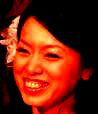

In [130]:
img2 = change_contrast(img, 100)
img2

In [76]:
random.randint(1, 30)

20

In [72]:
??random.randint

In [ ]:
import shutil
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
m = 0
for file in tqdm(list(img_path.glob("*.jpg"))):
    dir_path = file.parent/file.stem
    dir_path.mkdir(parents=True, exist_ok=True)    
    shutil.move(file, file.parent/file.stem/(str(file.stem)+'.jpg'))
    for i in range(40):
        #print(file.parent/file.stem/(str(file.stem)+'.jpg'))
        #print(i, "..........")
        newfile = PILImage.create(file.parent/file.stem/(str(file.stem)+'.jpg'))
        #print("newfile: ", newfile, ", type: ", type(newfile))
        do_rotate = random.randint(0,1)
        change_contrast = random.randint(0,1)
        #print("rotate: ", do_rotate, " change contrast: ", change_contrast)
        if do_rotate > 0:
            newfile = newfile.rotate(random.randint(1, 45))
            #print("A")
        if change_contrast > 0:
            #newfile2 = change_contrast(newfile, float(random.randint(-100, 100)+1))
            newfile2 = ImageEnhance.Contrast(newfile).enhance(float(random.randint(-100, 100)+1))
            #print("B")
        if change_contrast:
            newfile = newfile2
            del newfile2
        if change_contrast > 0 or do_rotate > 0:
            newfile.save(file.parent/file.stem/(str(file.stem)+f'_{i}.jpg'))




  0%|          | 0/86186 [00:00<?, ?it/s]


  0%|          | 4/86186 [00:00<40:07, 35.80it/s]


  0%|          | 6/86186 [00:00<1:49:30, 13.12it/s]


  0%|          | 8/86186 [00:00<1:46:44, 13.46it/s]


  0%|          | 10/86186 [00:00<1:57:51, 12.19it/s]


  0%|          | 12/86186 [00:00<1:48:37, 13.22it/s]


  0%|          | 14/86186 [00:01<1:40:40, 14.27it/s]


  0%|          | 16/86186 [00:01<2:33:54,  9.33it/s]


  0%|          | 18/86186 [00:01<2:32:29,  9.42it/s]


  0%|          | 20/86186 [00:01<2:16:23, 10.53it/s]


  0%|          | 22/86186 [00:01<1:58:58, 12.07it/s]


  0%|          | 25/86186 [00:02<1:46:01, 13.54it/s]


  0%|          | 28/86186 [00:02<1:40:26, 14.30it/s]


  0%|          | 31/86186 [00:02<1:36:12, 14.93it/s]


  0%|          | 33/86186 [00:02<1:40:03, 14.35it/s]


  0%|          | 36/86186 [00:02<1:49:25, 13.12it/s]


  0%|          | 40/86186 [00:02<1:29:09, 16.10it/s]


  0%|          | 42/86186 [00:03<1:55:41, 12.41it/s]


  0%|          | 44/861

  1%|          | 781/86186 [00:47<1:26:10, 16.52it/s]


  1%|          | 785/86186 [00:47<1:13:10, 19.45it/s]


  1%|          | 788/86186 [00:47<1:39:31, 14.30it/s]


  1%|          | 792/86186 [00:47<1:22:35, 17.23it/s]


  1%|          | 795/86186 [00:47<1:12:17, 19.69it/s]


  1%|          | 799/86186 [00:47<1:07:40, 21.03it/s]


  1%|          | 802/86186 [00:48<1:28:17, 16.12it/s]


  1%|          | 805/86186 [00:48<1:38:37, 14.43it/s]


  1%|          | 809/86186 [00:48<1:39:49, 14.26it/s]


  1%|          | 811/86186 [00:48<1:32:15, 15.42it/s]


  1%|          | 815/86186 [00:49<1:16:03, 18.71it/s]


  1%|          | 818/86186 [00:49<1:08:23, 20.80it/s]


  1%|          | 821/86186 [00:49<1:11:26, 19.91it/s]


  1%|          | 825/86186 [00:49<1:21:14, 17.51it/s]


  1%|          | 828/86186 [00:49<1:13:52, 19.26it/s]


  1%|          | 831/86186 [00:49<1:20:19, 17.71it/s]


  1%|          | 834/86186 [00:50<1:14:15, 19.16it/s]


  1%|          | 838/86186 [00:50<1:05:33, 21.70

  2%|▏         | 1553/86186 [01:33<1:18:20, 18.01it/s]


  2%|▏         | 1557/86186 [01:33<1:07:58, 20.75it/s]


  2%|▏         | 1560/86186 [01:34<1:14:44, 18.87it/s]


  2%|▏         | 1563/86186 [01:34<1:07:46, 20.81it/s]


  2%|▏         | 1566/86186 [01:34<1:16:17, 18.49it/s]


  2%|▏         | 1569/86186 [01:34<1:11:59, 19.59it/s]


  2%|▏         | 1572/86186 [01:34<1:06:27, 21.22it/s]


  2%|▏         | 1575/86186 [01:35<2:45:50,  8.50it/s]


  2%|▏         | 1577/86186 [01:35<2:23:41,  9.81it/s]


  2%|▏         | 1580/86186 [01:35<1:56:14, 12.13it/s]


  2%|▏         | 1583/86186 [01:35<1:41:28, 13.90it/s]


  2%|▏         | 1586/86186 [01:35<1:27:46, 16.06it/s]


  2%|▏         | 1590/86186 [01:36<1:20:28, 17.52it/s]


  2%|▏         | 1593/86186 [01:36<1:11:41, 19.67it/s]


  2%|▏         | 1596/86186 [01:36<1:19:49, 17.66it/s]


  2%|▏         | 1599/86186 [01:36<1:29:30, 15.75it/s]


  2%|▏         | 1602/86186 [01:36<1:20:58, 17.41it/s]


  2%|▏         | 1604/86186 [01

  3%|▎         | 2299/86186 [02:18<1:24:34, 16.53it/s]


  3%|▎         | 2302/86186 [02:18<1:13:20, 19.06it/s]


  3%|▎         | 2305/86186 [02:18<1:11:54, 19.44it/s]


  3%|▎         | 2308/86186 [02:19<2:26:57,  9.51it/s]


  3%|▎         | 2310/86186 [02:19<2:49:37,  8.24it/s]


  3%|▎         | 2313/86186 [02:19<2:17:51, 10.14it/s]


  3%|▎         | 2317/86186 [02:20<1:47:00, 13.06it/s]


  3%|▎         | 2320/86186 [02:20<1:30:25, 15.46it/s]


  3%|▎         | 2323/86186 [02:20<1:21:51, 17.07it/s]


  3%|▎         | 2327/86186 [02:20<1:10:10, 19.91it/s]


  3%|▎         | 2330/86186 [02:20<1:30:05, 15.51it/s]


  3%|▎         | 2333/86186 [02:20<1:20:18, 17.40it/s]


  3%|▎         | 2336/86186 [02:20<1:16:20, 18.31it/s]


  3%|▎         | 2339/86186 [02:21<1:13:03, 19.13it/s]


  3%|▎         | 2342/86186 [02:21<1:11:13, 19.62it/s]


  3%|▎         | 2345/86186 [02:22<2:35:54,  8.96it/s]


  3%|▎         | 2347/86186 [02:22<2:39:27,  8.76it/s]


  3%|▎         | 2349/86186 [02

  4%|▎         | 3054/86186 [03:05<1:51:42, 12.40it/s]


  4%|▎         | 3057/86186 [03:06<1:39:04, 13.98it/s]


  4%|▎         | 3060/86186 [03:06<1:23:50, 16.52it/s]


  4%|▎         | 3064/86186 [03:06<1:13:03, 18.96it/s]


  4%|▎         | 3067/86186 [03:06<1:52:24, 12.32it/s]


  4%|▎         | 3070/86186 [03:07<2:10:06, 10.65it/s]


  4%|▎         | 3073/86186 [03:07<1:47:20, 12.90it/s]


  4%|▎         | 3076/86186 [03:07<1:31:03, 15.21it/s]


  4%|▎         | 3079/86186 [03:07<1:37:15, 14.24it/s]


  4%|▎         | 3082/86186 [03:07<1:30:31, 15.30it/s]


  4%|▎         | 3084/86186 [03:08<2:53:17,  7.99it/s]


  4%|▎         | 3086/86186 [03:08<2:24:00,  9.62it/s]


  4%|▎         | 3089/86186 [03:08<2:00:59, 11.45it/s]


  4%|▎         | 3091/86186 [03:09<5:00:09,  4.61it/s]


  4%|▎         | 3093/86186 [03:09<4:05:45,  5.64it/s]


  4%|▎         | 3096/86186 [03:09<3:07:38,  7.38it/s]


  4%|▎         | 3100/86186 [03:10<2:23:08,  9.67it/s]


  4%|▎         | 3103/86186 [03

  4%|▍         | 3815/86186 [03:53<1:04:45, 21.20it/s]


  4%|▍         | 3818/86186 [03:53<1:00:37, 22.64it/s]


  4%|▍         | 3821/86186 [03:54<1:02:36, 21.93it/s]


  4%|▍         | 3824/86186 [03:54<2:02:07, 11.24it/s]


  4%|▍         | 3826/86186 [03:54<1:58:44, 11.56it/s]


  4%|▍         | 3828/86186 [03:55<2:30:42,  9.11it/s]


  4%|▍         | 3830/86186 [03:55<2:10:43, 10.50it/s]


  4%|▍         | 3832/86186 [03:55<1:55:19, 11.90it/s]


  4%|▍         | 3836/86186 [03:55<1:33:27, 14.69it/s]


  4%|▍         | 3839/86186 [03:55<1:22:27, 16.64it/s]


  4%|▍         | 3842/86186 [03:55<1:15:47, 18.11it/s]


  4%|▍         | 3846/86186 [03:55<1:05:42, 20.89it/s]


  4%|▍         | 3850/86186 [03:55<58:29, 23.46it/s]  


  4%|▍         | 3853/86186 [03:56<1:35:56, 14.30it/s]


  4%|▍         | 3856/86186 [03:56<1:34:46, 14.48it/s]


  4%|▍         | 3859/86186 [03:56<1:21:51, 16.76it/s]


  4%|▍         | 3862/86186 [03:56<1:13:57, 18.55it/s]


  4%|▍         | 3866/86186 [03

  5%|▌         | 4586/86186 [04:40<1:15:15, 18.07it/s]


  5%|▌         | 4589/86186 [04:41<2:00:22, 11.30it/s]


  5%|▌         | 4592/86186 [04:41<1:40:53, 13.48it/s]


  5%|▌         | 4595/86186 [04:41<1:34:17, 14.42it/s]


  5%|▌         | 4598/86186 [04:42<2:11:58, 10.30it/s]


  5%|▌         | 4601/86186 [04:42<1:48:27, 12.54it/s]


  5%|▌         | 4604/86186 [04:42<1:35:31, 14.23it/s]


  5%|▌         | 4607/86186 [04:42<1:24:22, 16.11it/s]


  5%|▌         | 4610/86186 [04:42<1:34:55, 14.32it/s]


  5%|▌         | 4612/86186 [04:43<1:34:07, 14.44it/s]


  5%|▌         | 4615/86186 [04:43<1:27:52, 15.47it/s]


  5%|▌         | 4618/86186 [04:43<1:20:03, 16.98it/s]


  5%|▌         | 4620/86186 [04:43<1:29:14, 15.23it/s]


  5%|▌         | 4623/86186 [04:43<1:23:23, 16.30it/s]


  5%|▌         | 4626/86186 [04:44<1:45:08, 12.93it/s]


  5%|▌         | 4628/86186 [04:44<1:34:04, 14.45it/s]


  5%|▌         | 4630/86186 [04:44<2:06:06, 10.78it/s]


  5%|▌         | 4633/86186 [04

  6%|▌         | 5326/86186 [05:27<1:48:32, 12.42it/s]


  6%|▌         | 5330/86186 [05:27<1:27:37, 15.38it/s]


  6%|▌         | 5334/86186 [05:27<1:14:24, 18.11it/s]


  6%|▌         | 5337/86186 [05:28<2:48:48,  7.98it/s]


  6%|▌         | 5341/86186 [05:28<2:10:21, 10.34it/s]


  6%|▌         | 5345/86186 [05:28<1:41:31, 13.27it/s]


  6%|▌         | 5348/86186 [05:28<1:48:41, 12.40it/s]


  6%|▌         | 5351/86186 [05:29<1:33:25, 14.42it/s]


  6%|▌         | 5354/86186 [05:29<1:35:21, 14.13it/s]


  6%|▌         | 5357/86186 [05:29<1:23:44, 16.09it/s]


  6%|▌         | 5360/86186 [05:29<1:51:24, 12.09it/s]


  6%|▌         | 5363/86186 [05:29<1:37:26, 13.82it/s]


  6%|▌         | 5366/86186 [05:30<1:36:26, 13.97it/s]


  6%|▌         | 5368/86186 [05:30<1:27:44, 15.35it/s]


  6%|▌         | 5372/86186 [05:30<1:14:18, 18.13it/s]


  6%|▌         | 5375/86186 [05:30<1:30:01, 14.96it/s]


  6%|▌         | 5378/86186 [05:30<1:18:48, 17.09it/s]


  6%|▌         | 5381/86186 [05

  7%|▋         | 6111/86186 [06:12<1:13:23, 18.18it/s]


  7%|▋         | 6113/86186 [06:12<1:13:41, 18.11it/s]


  7%|▋         | 6116/86186 [06:12<1:05:59, 20.22it/s]


  7%|▋         | 6119/86186 [06:12<1:05:14, 20.46it/s]


  7%|▋         | 6122/86186 [06:12<1:02:30, 21.35it/s]


  7%|▋         | 6126/86186 [06:12<1:04:11, 20.78it/s]


  7%|▋         | 6129/86186 [06:12<1:08:56, 19.35it/s]


  7%|▋         | 6132/86186 [06:13<1:11:35, 18.64it/s]


  7%|▋         | 6134/86186 [06:13<1:20:18, 16.61it/s]


  7%|▋         | 6137/86186 [06:13<1:15:53, 17.58it/s]


  7%|▋         | 6139/86186 [06:13<2:02:59, 10.85it/s]


  7%|▋         | 6141/86186 [06:14<4:12:39,  5.28it/s]


  7%|▋         | 6145/86186 [06:14<3:11:04,  6.98it/s]


  7%|▋         | 6147/86186 [06:14<2:51:47,  7.77it/s]


  7%|▋         | 6150/86186 [06:15<2:14:49,  9.89it/s]


  7%|▋         | 6153/86186 [06:15<1:54:13, 11.68it/s]


  7%|▋         | 6155/86186 [06:15<1:59:25, 11.17it/s]


  7%|▋         | 6158/86186 [06

  8%|▊         | 6858/86186 [06:57<1:07:38, 19.55it/s]


  8%|▊         | 6861/86186 [06:57<1:08:04, 19.42it/s]


  8%|▊         | 6864/86186 [06:57<1:05:56, 20.05it/s]


  8%|▊         | 6868/86186 [06:57<57:48, 22.87it/s]  


  8%|▊         | 6871/86186 [06:58<1:11:03, 18.60it/s]


  8%|▊         | 6874/86186 [06:58<1:34:26, 14.00it/s]


  8%|▊         | 6877/86186 [06:58<1:19:24, 16.65it/s]


  8%|▊         | 6880/86186 [06:58<1:55:50, 11.41it/s]


  8%|▊         | 6882/86186 [06:59<1:41:20, 13.04it/s]


  8%|▊         | 6885/86186 [06:59<1:57:16, 11.27it/s]


  8%|▊         | 6889/86186 [06:59<1:32:03, 14.36it/s]


  8%|▊         | 6893/86186 [06:59<1:15:43, 17.45it/s]


  8%|▊         | 6896/86186 [06:59<1:12:26, 18.24it/s]


  8%|▊         | 6900/86186 [06:59<1:01:23, 21.53it/s]


  8%|▊         | 6903/86186 [07:00<1:51:13, 11.88it/s]


  8%|▊         | 6906/86186 [07:00<1:57:47, 11.22it/s]


  8%|▊         | 6910/86186 [07:00<1:34:29, 13.98it/s]


  8%|▊         | 6913/86186 [07

  9%|▉         | 7625/86186 [07:45<2:52:59,  7.57it/s]


  9%|▉         | 7628/86186 [07:45<2:16:14,  9.61it/s]


  9%|▉         | 7631/86186 [07:45<1:54:15, 11.46it/s]


  9%|▉         | 7633/86186 [07:45<1:57:45, 11.12it/s]


  9%|▉         | 7636/86186 [07:45<1:36:30, 13.57it/s]


  9%|▉         | 7638/86186 [07:45<1:28:49, 14.74it/s]


  9%|▉         | 7640/86186 [07:45<1:52:30, 11.64it/s]


  9%|▉         | 7642/86186 [07:46<1:42:24, 12.78it/s]


  9%|▉         | 7644/86186 [07:46<1:34:10, 13.90it/s]


  9%|▉         | 7647/86186 [07:46<1:28:51, 14.73it/s]


  9%|▉         | 7651/86186 [07:46<1:14:00, 17.69it/s]


  9%|▉         | 7654/86186 [07:46<1:08:36, 19.08it/s]


  9%|▉         | 7657/86186 [07:46<1:07:58, 19.25it/s]


  9%|▉         | 7660/86186 [07:46<1:03:22, 20.65it/s]


  9%|▉         | 7664/86186 [07:46<57:22, 22.81it/s]  


  9%|▉         | 7667/86186 [07:47<1:37:01, 13.49it/s]


  9%|▉         | 7671/86186 [07:47<1:18:38, 16.64it/s]


  9%|▉         | 7674/86186 [07

 10%|▉         | 8379/86186 [08:32<57:17, 22.64it/s]


 10%|▉         | 8382/86186 [08:32<1:13:51, 17.56it/s]


 10%|▉         | 8385/86186 [08:32<1:04:48, 20.01it/s]


 10%|▉         | 8388/86186 [08:32<59:50, 21.67it/s]  


 10%|▉         | 8391/86186 [08:32<1:15:02, 17.28it/s]


 10%|▉         | 8394/86186 [08:32<1:07:17, 19.27it/s]


 10%|▉         | 8397/86186 [08:33<1:01:24, 21.11it/s]


 10%|▉         | 8400/86186 [08:33<1:16:18, 16.99it/s]


 10%|▉         | 8403/86186 [08:33<1:25:49, 15.11it/s]


 10%|▉         | 8406/86186 [08:33<1:22:28, 15.72it/s]


 10%|▉         | 8408/86186 [08:33<1:19:07, 16.38it/s]


 10%|▉         | 8411/86186 [08:33<1:11:10, 18.21it/s]


 10%|▉         | 8414/86186 [08:34<1:12:22, 17.91it/s]


 10%|▉         | 8416/86186 [08:34<1:10:34, 18.37it/s]


 10%|▉         | 8420/86186 [08:34<1:03:26, 20.43it/s]


 10%|▉         | 8423/86186 [08:34<1:06:49, 19.40it/s]


 10%|▉         | 8426/86186 [08:34<1:15:16, 17.22it/s]


 10%|▉         | 8430/86186 [08:3

 11%|█         | 9117/86186 [09:18<1:25:56, 14.95it/s]


 11%|█         | 9119/86186 [09:19<1:33:30, 13.74it/s]


 11%|█         | 9122/86186 [09:19<1:18:52, 16.28it/s]


 11%|█         | 9126/86186 [09:19<1:05:31, 19.60it/s]


 11%|█         | 9130/86186 [09:19<59:45, 21.49it/s]  


 11%|█         | 9134/86186 [09:19<52:11, 24.60it/s]


 11%|█         | 9137/86186 [09:19<57:28, 22.34it/s]


 11%|█         | 9140/86186 [09:19<1:05:34, 19.58it/s]


 11%|█         | 9144/86186 [09:19<56:00, 22.93it/s]  


 11%|█         | 9147/86186 [09:20<1:12:00, 17.83it/s]


 11%|█         | 9150/86186 [09:20<1:05:57, 19.46it/s]


 11%|█         | 9153/86186 [09:20<59:07, 21.71it/s]  


 11%|█         | 9156/86186 [09:20<57:25, 22.36it/s]


 11%|█         | 9159/86186 [09:20<1:11:57, 17.84it/s]


 11%|█         | 9163/86186 [09:20<1:01:37, 20.83it/s]


 11%|█         | 9166/86186 [09:21<1:24:16, 15.23it/s]


 11%|█         | 9170/86186 [09:21<1:08:57, 18.61it/s]


 11%|█         | 9174/86186 [09:21<1:

 11%|█▏        | 9876/86186 [10:03<51:25, 24.73it/s]


 11%|█▏        | 9879/86186 [10:03<1:13:30, 17.30it/s]


 11%|█▏        | 9882/86186 [10:04<1:25:20, 14.90it/s]


 11%|█▏        | 9886/86186 [10:04<1:10:23, 18.07it/s]


 11%|█▏        | 9889/86186 [10:04<1:37:51, 12.99it/s]


 11%|█▏        | 9891/86186 [10:05<2:59:37,  7.08it/s]


 11%|█▏        | 9893/86186 [10:05<2:25:19,  8.75it/s]


 11%|█▏        | 9895/86186 [10:05<2:04:52, 10.18it/s]


 11%|█▏        | 9897/86186 [10:05<2:06:19, 10.07it/s]


 11%|█▏        | 9899/86186 [10:05<1:49:25, 11.62it/s]


 11%|█▏        | 9903/86186 [10:05<1:31:46, 13.85it/s]


 11%|█▏        | 9907/86186 [10:06<1:17:31, 16.40it/s]


 11%|█▏        | 9910/86186 [10:06<1:35:48, 13.27it/s]


 12%|█▏        | 9912/86186 [10:06<1:41:55, 12.47it/s]


 12%|█▏        | 9915/86186 [10:06<1:26:57, 14.62it/s]


 12%|█▏        | 9918/86186 [10:06<1:15:27, 16.84it/s]


 12%|█▏        | 9922/86186 [10:06<1:05:23, 19.44it/s]


 12%|█▏        | 9925/86186 [10:0

 12%|█▏        | 10642/86186 [10:49<1:04:11, 19.62it/s]


 12%|█▏        | 10645/86186 [10:49<57:34, 21.87it/s]  


 12%|█▏        | 10648/86186 [10:49<1:14:13, 16.96it/s]


 12%|█▏        | 10651/86186 [10:49<1:09:11, 18.19it/s]


 12%|█▏        | 10655/86186 [10:49<58:24, 21.56it/s]  


 12%|█▏        | 10659/86186 [10:49<51:20, 24.52it/s]


 12%|█▏        | 10663/86186 [10:50<50:45, 24.80it/s]


 12%|█▏        | 10666/86186 [10:50<54:41, 23.01it/s]


 12%|█▏        | 10669/86186 [10:50<51:29, 24.44it/s]


 12%|█▏        | 10672/86186 [10:50<52:20, 24.05it/s]


 12%|█▏        | 10675/86186 [10:50<50:33, 24.89it/s]


 12%|█▏        | 10678/86186 [10:50<55:26, 22.70it/s]


 12%|█▏        | 10682/86186 [10:50<49:48, 25.27it/s]


 12%|█▏        | 10685/86186 [10:50<50:00, 25.16it/s]


 12%|█▏        | 10688/86186 [10:51<1:19:20, 15.86it/s]


 12%|█▏        | 10691/86186 [10:51<1:21:47, 15.38it/s]


 12%|█▏        | 10694/86186 [10:51<1:14:05, 16.98it/s]


 12%|█▏        | 10698/86186 [10

 13%|█▎        | 11394/86186 [11:34<1:16:24, 16.31it/s]


 13%|█▎        | 11397/86186 [11:34<1:12:22, 17.22it/s]


 13%|█▎        | 11401/86186 [11:34<1:04:04, 19.45it/s]


 13%|█▎        | 11404/86186 [11:34<1:01:18, 20.33it/s]


 13%|█▎        | 11408/86186 [11:34<55:52, 22.30it/s]  


 13%|█▎        | 11411/86186 [11:35<1:32:57, 13.41it/s]


 13%|█▎        | 11413/86186 [11:35<1:52:43, 11.06it/s]


 13%|█▎        | 11415/86186 [11:35<1:40:17, 12.42it/s]


 13%|█▎        | 11418/86186 [11:35<1:25:01, 14.65it/s]


 13%|█▎        | 11422/86186 [11:35<1:11:30, 17.42it/s]


 13%|█▎        | 11425/86186 [11:35<1:02:41, 19.87it/s]


 13%|█▎        | 11428/86186 [11:36<57:20, 21.73it/s]  


 13%|█▎        | 11432/86186 [11:36<50:43, 24.57it/s]


 13%|█▎        | 11435/86186 [11:36<1:14:37, 16.69it/s]


 13%|█▎        | 11438/86186 [11:36<1:07:39, 18.41it/s]


 13%|█▎        | 11441/86186 [11:36<1:08:41, 18.14it/s]


 13%|█▎        | 11444/86186 [11:36<1:02:46, 19.84it/s]


 13%|█▎        |

 14%|█▍        | 12163/86186 [12:21<1:21:32, 15.13it/s]


 14%|█▍        | 12166/86186 [12:21<1:11:38, 17.22it/s]


 14%|█▍        | 12170/86186 [12:21<1:02:40, 19.68it/s]


 14%|█▍        | 12173/86186 [12:22<1:24:55, 14.53it/s]


 14%|█▍        | 12176/86186 [12:22<1:11:51, 17.17it/s]


 14%|█▍        | 12180/86186 [12:22<1:01:25, 20.08it/s]


 14%|█▍        | 12183/86186 [12:22<1:15:29, 16.34it/s]


 14%|█▍        | 12186/86186 [12:22<1:35:04, 12.97it/s]


 14%|█▍        | 12189/86186 [12:22<1:22:49, 14.89it/s]


 14%|█▍        | 12191/86186 [12:23<1:20:18, 15.36it/s]


 14%|█▍        | 12194/86186 [12:23<1:14:30, 16.55it/s]


 14%|█▍        | 12196/86186 [12:23<1:14:31, 16.55it/s]


 14%|█▍        | 12198/86186 [12:23<1:17:23, 15.93it/s]


 14%|█▍        | 12202/86186 [12:23<1:10:11, 17.57it/s]


 14%|█▍        | 12206/86186 [12:23<1:00:56, 20.23it/s]


 14%|█▍        | 12209/86186 [12:23<1:02:16, 19.80it/s]


 14%|█▍        | 12212/86186 [12:24<56:54, 21.67it/s]  


 14%|█▍       

 15%|█▍        | 12910/86186 [13:06<1:40:30, 12.15it/s]


 15%|█▍        | 12913/86186 [13:06<1:34:23, 12.94it/s]


 15%|█▍        | 12916/86186 [13:06<1:20:55, 15.09it/s]


 15%|█▍        | 12919/86186 [13:06<1:09:55, 17.46it/s]


 15%|█▍        | 12922/86186 [13:07<1:24:06, 14.52it/s]


 15%|█▍        | 12924/86186 [13:07<2:19:29,  8.75it/s]


 15%|█▍        | 12927/86186 [13:07<1:53:31, 10.75it/s]


 15%|█▌        | 12930/86186 [13:08<2:29:06,  8.19it/s]


 15%|█▌        | 12933/86186 [13:08<2:00:48, 10.11it/s]


 15%|█▌        | 12935/86186 [13:08<2:16:20,  8.95it/s]


 15%|█▌        | 12937/86186 [13:08<1:59:02, 10.26it/s]


 15%|█▌        | 12939/86186 [13:09<2:03:16,  9.90it/s]


 15%|█▌        | 12942/86186 [13:09<2:00:51, 10.10it/s]


 15%|█▌        | 12946/86186 [13:09<1:35:47, 12.74it/s]


 15%|█▌        | 12948/86186 [13:09<2:21:08,  8.65it/s]


 15%|█▌        | 12951/86186 [13:10<1:53:39, 10.74it/s]


 15%|█▌        | 12953/86186 [13:10<1:47:29, 11.35it/s]


 15%|█▌       

 16%|█▌        | 13642/86186 [13:53<1:26:53, 13.91it/s]


 16%|█▌        | 13645/86186 [13:53<1:18:43, 15.36it/s]


 16%|█▌        | 13648/86186 [13:53<1:10:13, 17.22it/s]


 16%|█▌        | 13652/86186 [13:53<59:57, 20.16it/s]  


 16%|█▌        | 13655/86186 [13:54<59:35, 20.29it/s]


 16%|█▌        | 13658/86186 [13:54<1:14:11, 16.29it/s]


 16%|█▌        | 13661/86186 [13:54<1:05:37, 18.42it/s]


 16%|█▌        | 13664/86186 [13:54<1:03:37, 19.00it/s]


 16%|█▌        | 13667/86186 [13:54<1:02:55, 19.21it/s]


 16%|█▌        | 13670/86186 [13:54<1:05:12, 18.53it/s]


 16%|█▌        | 13672/86186 [13:55<1:18:34, 15.38it/s]


 16%|█▌        | 13676/86186 [13:55<1:05:04, 18.57it/s]


 16%|█▌        | 13679/86186 [13:55<1:54:07, 10.59it/s]


 16%|█▌        | 13683/86186 [13:55<1:30:44, 13.32it/s]


 16%|█▌        | 13687/86186 [13:56<1:16:01, 15.89it/s]


 16%|█▌        | 13690/86186 [13:56<1:14:12, 16.28it/s]


 16%|█▌        | 13693/86186 [13:56<1:07:09, 17.99it/s]


 16%|█▌        |

 17%|█▋        | 14387/86186 [14:39<1:33:38, 12.78it/s]


 17%|█▋        | 14390/86186 [14:39<1:19:04, 15.13it/s]


 17%|█▋        | 14393/86186 [14:39<1:19:19, 15.08it/s]


 17%|█▋        | 14396/86186 [14:40<1:26:16, 13.87it/s]


 17%|█▋        | 14400/86186 [14:40<1:09:46, 17.15it/s]


 17%|█▋        | 14403/86186 [14:40<1:09:34, 17.20it/s]


 17%|█▋        | 14406/86186 [14:40<1:03:17, 18.90it/s]


 17%|█▋        | 14410/86186 [14:40<54:02, 22.14it/s]  


 17%|█▋        | 14413/86186 [14:41<1:21:51, 14.61it/s]


 17%|█▋        | 14416/86186 [14:41<1:15:49, 15.78it/s]


 17%|█▋        | 14420/86186 [14:41<1:19:36, 15.02it/s]


 17%|█▋        | 14422/86186 [14:41<2:12:13,  9.05it/s]


 17%|█▋        | 14426/86186 [14:42<1:42:05, 11.72it/s]


 17%|█▋        | 14429/86186 [14:42<1:24:05, 14.22it/s]


 17%|█▋        | 14432/86186 [14:42<1:13:30, 16.27it/s]


 17%|█▋        | 14436/86186 [14:42<1:08:53, 17.36it/s]


 17%|█▋        | 14439/86186 [14:42<1:04:04, 18.66it/s]


 17%|█▋       

 18%|█▊        | 15145/86186 [15:25<50:03, 23.65it/s]


 18%|█▊        | 15149/86186 [15:25<45:05, 26.25it/s]


 18%|█▊        | 15152/86186 [15:25<59:41, 19.83it/s]


 18%|█▊        | 15156/86186 [15:25<53:07, 22.29it/s]


 18%|█▊        | 15159/86186 [15:25<58:39, 20.18it/s]


 18%|█▊        | 15163/86186 [15:25<50:57, 23.23it/s]


 18%|█▊        | 15166/86186 [15:25<49:05, 24.11it/s]


 18%|█▊        | 15169/86186 [15:26<1:05:07, 18.18it/s]


 18%|█▊        | 15172/86186 [15:26<1:00:01, 19.72it/s]


 18%|█▊        | 15175/86186 [15:26<56:05, 21.10it/s]  


 18%|█▊        | 15178/86186 [15:26<53:56, 21.94it/s]


 18%|█▊        | 15182/86186 [15:26<1:03:04, 18.76it/s]


 18%|█▊        | 15186/86186 [15:27<53:23, 22.16it/s]  


 18%|█▊        | 15189/86186 [15:27<1:12:31, 16.31it/s]


 18%|█▊        | 15192/86186 [15:27<1:08:01, 17.40it/s]


 18%|█▊        | 15195/86186 [15:27<1:00:36, 19.52it/s]


 18%|█▊        | 15198/86186 [15:27<1:04:37, 18.31it/s]


 18%|█▊        | 15201/86186 [

 18%|█▊        | 15906/86186 [16:09<1:12:01, 16.26it/s]


 18%|█▊        | 15909/86186 [16:09<1:05:15, 17.95it/s]


 18%|█▊        | 15912/86186 [16:10<1:23:28, 14.03it/s]


 18%|█▊        | 15914/86186 [16:10<1:35:34, 12.25it/s]


 18%|█▊        | 15918/86186 [16:10<1:19:58, 14.65it/s]


 18%|█▊        | 15921/86186 [16:10<1:09:13, 16.92it/s]


 18%|█▊        | 15924/86186 [16:10<1:15:18, 15.55it/s]


 18%|█▊        | 15926/86186 [16:11<1:53:07, 10.35it/s]


 18%|█▊        | 15928/86186 [16:11<1:44:00, 11.26it/s]


 18%|█▊        | 15930/86186 [16:12<3:18:21,  5.90it/s]


 18%|█▊        | 15932/86186 [16:12<2:36:32,  7.48it/s]


 18%|█▊        | 15934/86186 [16:12<2:20:46,  8.32it/s]


 18%|█▊        | 15936/86186 [16:12<1:59:03,  9.83it/s]


 18%|█▊        | 15940/86186 [16:12<1:41:08, 11.57it/s]


 18%|█▊        | 15943/86186 [16:12<1:25:44, 13.65it/s]


 19%|█▊        | 15946/86186 [16:13<1:14:16, 15.76it/s]


 19%|█▊        | 15949/86186 [16:13<1:15:49, 15.44it/s]


 19%|█▊       

 19%|█▉        | 16277/86186 [16:33<2:43:52,  7.11it/s]


 19%|█▉        | 16281/86186 [16:33<2:04:34,  9.35it/s]


 19%|█▉        | 16284/86186 [16:33<1:38:59, 11.77it/s]


 19%|█▉        | 16288/86186 [16:33<1:20:22, 14.50it/s]


 19%|█▉        | 16291/86186 [16:33<1:17:00, 15.13it/s]


 19%|█▉        | 16294/86186 [16:33<1:08:16, 17.06it/s]


 19%|█▉        | 16297/86186 [16:34<1:06:57, 17.40it/s]


 19%|█▉        | 16300/86186 [16:34<1:02:59, 18.49it/s]


 19%|█▉        | 16304/86186 [16:34<53:20, 21.83it/s]  


 19%|█▉        | 16308/86186 [16:34<46:32, 25.02it/s]


 19%|█▉        | 16312/86186 [16:34<49:51, 23.36it/s]


 19%|█▉        | 16315/86186 [16:34<52:32, 22.16it/s]


 19%|█▉        | 16318/86186 [16:35<1:07:48, 17.17it/s]


 19%|█▉        | 16321/86186 [16:35<1:11:53, 16.20it/s]


 19%|█▉        | 16324/86186 [16:35<1:07:05, 17.35it/s]


 19%|█▉        | 16328/86186 [16:35<57:51, 20.12it/s]  


 19%|█▉        | 16331/86186 [16:35<1:09:36, 16.72it/s]


 19%|█▉        | 163

 20%|█▉        | 17028/86186 [17:18<1:02:28, 18.45it/s]


 20%|█▉        | 17030/86186 [17:18<1:04:01, 18.00it/s]


 20%|█▉        | 17032/86186 [17:18<2:01:00,  9.52it/s]


 20%|█▉        | 17036/86186 [17:19<1:38:23, 11.71it/s]


 20%|█▉        | 17039/86186 [17:19<1:22:28, 13.97it/s]


 20%|█▉        | 17043/86186 [17:19<1:06:39, 17.29it/s]


 20%|█▉        | 17046/86186 [17:19<1:06:16, 17.39it/s]


 20%|█▉        | 17049/86186 [17:19<59:51, 19.25it/s]  


 20%|█▉        | 17052/86186 [17:19<1:20:41, 14.28it/s]


 20%|█▉        | 17054/86186 [17:20<1:21:11, 14.19it/s]


 20%|█▉        | 17056/86186 [17:20<1:40:28, 11.47it/s]


 20%|█▉        | 17058/86186 [17:20<2:16:21,  8.45it/s]


 20%|█▉        | 17062/86186 [17:20<1:46:13, 10.85it/s]


 20%|█▉        | 17064/86186 [17:20<1:37:10, 11.86it/s]


 20%|█▉        | 17069/86186 [17:21<1:27:42, 13.13it/s]


 20%|█▉        | 17072/86186 [17:21<1:14:59, 15.36it/s]


 20%|█▉        | 17074/86186 [17:21<1:15:03, 15.35it/s]


 20%|█▉       

 21%|██        | 17785/86186 [18:03<1:02:23, 18.27it/s]


 21%|██        | 17789/86186 [18:04<56:44, 20.09it/s]  


 21%|██        | 17793/86186 [18:04<1:10:26, 16.18it/s]


 21%|██        | 17797/86186 [18:04<1:00:14, 18.92it/s]


 21%|██        | 17800/86186 [18:04<1:14:12, 15.36it/s]


 21%|██        | 17803/86186 [18:05<1:19:38, 14.31it/s]


 21%|██        | 17805/86186 [18:05<1:19:54, 14.26it/s]


 21%|██        | 17808/86186 [18:05<1:26:54, 13.11it/s]


 21%|██        | 17811/86186 [18:05<1:15:06, 15.17it/s]


 21%|██        | 17813/86186 [18:05<1:37:59, 11.63it/s]


 21%|██        | 17817/86186 [18:06<1:20:57, 14.08it/s]


 21%|██        | 17821/86186 [18:06<1:29:47, 12.69it/s]


 21%|██        | 17824/86186 [18:06<1:25:09, 13.38it/s]


 21%|██        | 17826/86186 [18:06<1:49:07, 10.44it/s]


 21%|██        | 17829/86186 [18:06<1:28:27, 12.88it/s]


 21%|██        | 17832/86186 [18:07<1:13:43, 15.45it/s]


 21%|██        | 17836/86186 [18:07<1:02:29, 18.23it/s]


 21%|██       

 21%|██        | 18157/86186 [18:28<1:02:38, 18.10it/s]


 21%|██        | 18160/86186 [18:28<1:14:06, 15.30it/s]


 21%|██        | 18163/86186 [18:28<1:06:25, 17.07it/s]


 21%|██        | 18167/86186 [18:28<55:13, 20.53it/s]  


 21%|██        | 18170/86186 [18:28<52:45, 21.49it/s]


 21%|██        | 18173/86186 [18:28<1:00:34, 18.71it/s]


 21%|██        | 18176/86186 [18:29<55:47, 20.32it/s]  


 21%|██        | 18179/86186 [18:29<56:45, 19.97it/s]


 21%|██        | 18182/86186 [18:29<52:34, 21.56it/s]


 21%|██        | 18185/86186 [18:29<48:11, 23.52it/s]


 21%|██        | 18188/86186 [18:29<45:18, 25.01it/s]


 21%|██        | 18191/86186 [18:29<52:59, 21.38it/s]


 21%|██        | 18195/86186 [18:29<49:05, 23.08it/s]


 21%|██        | 18198/86186 [18:29<50:54, 22.26it/s]


 21%|██        | 18202/86186 [18:30<1:04:27, 17.58it/s]


 21%|██        | 18205/86186 [18:30<1:03:27, 17.85it/s]


 21%|██        | 18208/86186 [18:30<56:27, 20.07it/s]  


 21%|██        | 18211/86186 [

 22%|██▏       | 18895/86186 [19:14<1:35:22, 11.76it/s]


 22%|██▏       | 18897/86186 [19:14<1:43:42, 10.81it/s]


 22%|██▏       | 18901/86186 [19:14<1:26:45, 12.93it/s]


 22%|██▏       | 18905/86186 [19:15<1:09:50, 16.05it/s]


 22%|██▏       | 18908/86186 [19:15<1:03:26, 17.68it/s]


 22%|██▏       | 18911/86186 [19:15<1:49:11, 10.27it/s]


 22%|██▏       | 18913/86186 [19:15<1:34:22, 11.88it/s]


 22%|██▏       | 18917/86186 [19:16<1:33:07, 12.04it/s]


 22%|██▏       | 18921/86186 [19:16<1:16:37, 14.63it/s]


 22%|██▏       | 18924/86186 [19:16<1:04:58, 17.25it/s]


 22%|██▏       | 18927/86186 [19:16<57:08, 19.62it/s]  


 22%|██▏       | 18930/86186 [19:16<1:04:04, 17.49it/s]


 22%|██▏       | 18933/86186 [19:17<1:14:33, 15.03it/s]


 22%|██▏       | 18937/86186 [19:18<2:24:42,  7.75it/s]


 22%|██▏       | 18940/86186 [19:18<1:53:36,  9.87it/s]


 22%|██▏       | 18943/86186 [19:18<1:34:19, 11.88it/s]


 22%|██▏       | 18946/86186 [19:18<1:29:30, 12.52it/s]


 22%|██▏      

 22%|██▏       | 19281/86186 [19:38<1:01:55, 18.01it/s]


 22%|██▏       | 19284/86186 [19:38<58:59, 18.90it/s]  


 22%|██▏       | 19287/86186 [19:38<54:11, 20.57it/s]


 22%|██▏       | 19290/86186 [19:38<1:02:04, 17.96it/s]


 22%|██▏       | 19293/86186 [19:39<56:39, 19.68it/s]  


 22%|██▏       | 19296/86186 [19:39<1:58:36,  9.40it/s]


 22%|██▏       | 19298/86186 [19:39<1:44:44, 10.64it/s]


 22%|██▏       | 19300/86186 [19:40<1:31:55, 12.13it/s]


 22%|██▏       | 19303/86186 [19:40<1:16:17, 14.61it/s]


 22%|██▏       | 19306/86186 [19:40<1:06:48, 16.68it/s]


 22%|██▏       | 19310/86186 [19:40<55:16, 20.17it/s]  


 22%|██▏       | 19313/86186 [19:40<52:56, 21.05it/s]


 22%|██▏       | 19316/86186 [19:40<49:59, 22.30it/s]


 22%|██▏       | 19319/86186 [19:40<46:59, 23.71it/s]


 22%|██▏       | 19323/86186 [19:40<41:51, 26.62it/s]


 22%|██▏       | 19326/86186 [19:40<41:24, 26.91it/s]


 22%|██▏       | 19329/86186 [19:41<44:06, 25.26it/s]


 22%|██▏       | 19332/86186

 23%|██▎       | 19999/86186 [20:23<52:34, 20.98it/s]


 23%|██▎       | 20002/86186 [20:23<52:57, 20.83it/s]


 23%|██▎       | 20005/86186 [20:23<57:54, 19.05it/s]


 23%|██▎       | 20008/86186 [20:24<1:26:35, 12.74it/s]


 23%|██▎       | 20012/86186 [20:24<1:10:08, 15.72it/s]


 23%|██▎       | 20016/86186 [20:24<59:32, 18.52it/s]  


 23%|██▎       | 20019/86186 [20:24<57:49, 19.07it/s]


 23%|██▎       | 20022/86186 [20:24<1:10:34, 15.62it/s]


 23%|██▎       | 20025/86186 [20:25<1:01:08, 18.04it/s]


 23%|██▎       | 20028/86186 [20:25<54:40, 20.17it/s]  


 23%|██▎       | 20032/86186 [20:25<48:45, 22.61it/s]


 23%|██▎       | 20035/86186 [20:25<1:08:52, 16.01it/s]


 23%|██▎       | 20038/86186 [20:25<1:00:07, 18.33it/s]


 23%|██▎       | 20041/86186 [20:25<56:27, 19.53it/s]  


 23%|██▎       | 20044/86186 [20:26<1:11:28, 15.42it/s]


 23%|██▎       | 20047/86186 [20:26<1:03:24, 17.39it/s]


 23%|██▎       | 20050/86186 [20:26<56:16, 19.59it/s]  


 23%|██▎       | 20053/8

 24%|██▍       | 20731/86186 [21:11<1:29:53, 12.14it/s]


 24%|██▍       | 20734/86186 [21:11<1:14:58, 14.55it/s]


 24%|██▍       | 20736/86186 [21:11<1:14:03, 14.73it/s]


 24%|██▍       | 20740/86186 [21:11<1:01:00, 17.88it/s]


 24%|██▍       | 20743/86186 [21:11<56:01, 19.47it/s]  


 24%|██▍       | 20747/86186 [21:12<1:30:11, 12.09it/s]


 24%|██▍       | 20751/86186 [21:12<1:12:31, 15.04it/s]


 24%|██▍       | 20754/86186 [21:13<1:25:05, 12.82it/s]


 24%|██▍       | 20757/86186 [21:13<1:13:23, 14.86it/s]


 24%|██▍       | 20760/86186 [21:13<1:07:20, 16.19it/s]


 24%|██▍       | 20764/86186 [21:13<57:04, 19.10it/s]  


 24%|██▍       | 20767/86186 [21:13<55:01, 19.81it/s]


 24%|██▍       | 20771/86186 [21:13<48:04, 22.68it/s]


 24%|██▍       | 20774/86186 [21:13<47:40, 22.87it/s]


 24%|██▍       | 20778/86186 [21:13<47:02, 23.17it/s]


 24%|██▍       | 20781/86186 [21:14<56:33, 19.27it/s]


 24%|██▍       | 20784/86186 [21:14<50:52, 21.43it/s]


 24%|██▍       | 20787/861

 25%|██▍       | 21481/86186 [21:56<53:07, 20.30it/s]  


 25%|██▍       | 21484/86186 [21:56<51:03, 21.12it/s]


 25%|██▍       | 21488/86186 [21:56<44:39, 24.14it/s]


 25%|██▍       | 21491/86186 [21:56<43:34, 24.75it/s]


 25%|██▍       | 21494/86186 [21:56<51:36, 20.89it/s]


 25%|██▍       | 21497/86186 [21:57<1:21:10, 13.28it/s]


 25%|██▍       | 21499/86186 [21:57<1:22:14, 13.11it/s]


 25%|██▍       | 21501/86186 [21:58<3:21:48,  5.34it/s]


 25%|██▍       | 21505/86186 [21:58<2:33:49,  7.01it/s]


 25%|██▍       | 21508/86186 [21:58<2:28:00,  7.28it/s]


 25%|██▍       | 21512/86186 [21:59<2:01:57,  8.84it/s]


 25%|██▍       | 21516/86186 [21:59<1:35:34, 11.28it/s]


 25%|██▍       | 21520/86186 [21:59<1:16:51, 14.02it/s]


 25%|██▍       | 21523/86186 [21:59<1:22:51, 13.01it/s]


 25%|██▍       | 21525/86186 [21:59<1:16:00, 14.18it/s]


 25%|██▍       | 21528/86186 [21:59<1:07:03, 16.07it/s]


 25%|██▍       | 21531/86186 [21:59<59:14, 18.19it/s]  


 25%|██▍       | 21534

 26%|██▌       | 22268/86186 [22:42<1:27:41, 12.15it/s]


 26%|██▌       | 22271/86186 [22:42<1:13:27, 14.50it/s]


 26%|██▌       | 22274/86186 [22:42<1:03:53, 16.67it/s]


 26%|██▌       | 22278/86186 [22:42<1:12:09, 14.76it/s]


 26%|██▌       | 22282/86186 [22:42<59:47, 17.81it/s]  


 26%|██▌       | 22285/86186 [22:43<1:27:14, 12.21it/s]


 26%|██▌       | 22287/86186 [22:43<1:35:16, 11.18it/s]


 26%|██▌       | 22289/86186 [22:44<4:38:20,  3.83it/s]


 26%|██▌       | 22292/86186 [22:44<3:26:00,  5.17it/s]


 26%|██▌       | 22294/86186 [22:44<2:40:39,  6.63it/s]


 26%|██▌       | 22296/86186 [22:45<3:41:07,  4.82it/s]


 26%|██▌       | 22298/86186 [22:45<3:04:36,  5.77it/s]


 26%|██▌       | 22301/86186 [22:45<2:20:25,  7.58it/s]


 26%|██▌       | 22305/86186 [22:46<1:49:32,  9.72it/s]


 26%|██▌       | 22308/86186 [22:46<1:28:10, 12.07it/s]


 26%|██▌       | 22312/86186 [22:46<1:11:56, 14.80it/s]


 26%|██▌       | 22315/86186 [22:46<1:01:15, 17.38it/s]


 26%|██▌      

 27%|██▋       | 23019/86186 [23:30<1:06:51, 15.74it/s]


 27%|██▋       | 23022/86186 [23:31<1:22:37, 12.74it/s]


 27%|██▋       | 23025/86186 [23:31<1:09:02, 15.25it/s]


 27%|██▋       | 23028/86186 [23:31<1:29:10, 11.80it/s]


 27%|██▋       | 23030/86186 [23:31<1:29:37, 11.74it/s]


 27%|██▋       | 23032/86186 [23:31<1:21:03, 12.98it/s]


 27%|██▋       | 23034/86186 [23:31<1:15:00, 14.03it/s]


 27%|██▋       | 23038/86186 [23:32<1:00:49, 17.30it/s]


 27%|██▋       | 23041/86186 [23:32<55:38, 18.91it/s]  


 27%|██▋       | 23044/86186 [23:32<55:52, 18.83it/s]


 27%|██▋       | 23048/86186 [23:32<48:57, 21.49it/s]


 27%|██▋       | 23051/86186 [23:32<59:54, 17.57it/s]


 27%|██▋       | 23054/86186 [23:32<54:40, 19.24it/s]


 27%|██▋       | 23057/86186 [23:33<57:01, 18.45it/s]


 27%|██▋       | 23060/86186 [23:33<57:56, 18.16it/s]


 27%|██▋       | 23063/86186 [23:33<58:44, 17.91it/s]


 27%|██▋       | 23065/86186 [23:33<58:12, 18.07it/s]


 27%|██▋       | 23068/86186 [

 28%|██▊       | 23787/86186 [24:18<48:22, 21.50it/s]


 28%|██▊       | 23790/86186 [24:18<45:29, 22.86it/s]


 28%|██▊       | 23793/86186 [24:19<45:06, 23.06it/s]


 28%|██▊       | 23796/86186 [24:19<1:09:03, 15.06it/s]


 28%|██▊       | 23798/86186 [24:19<1:11:18, 14.58it/s]


 28%|██▊       | 23801/86186 [24:19<1:01:13, 16.98it/s]


 28%|██▊       | 23804/86186 [24:19<1:12:06, 14.42it/s]


 28%|██▊       | 23807/86186 [24:20<1:01:51, 16.81it/s]


 28%|██▊       | 23812/86186 [24:20<1:28:32, 11.74it/s]


 28%|██▊       | 23814/86186 [24:20<1:21:29, 12.76it/s]


 28%|██▊       | 23816/86186 [24:21<1:25:30, 12.16it/s]


 28%|██▊       | 23818/86186 [24:21<1:16:27, 13.60it/s]


 28%|██▊       | 23821/86186 [24:21<1:16:52, 13.52it/s]


 28%|██▊       | 23823/86186 [24:21<1:31:31, 11.36it/s]


 28%|██▊       | 23826/86186 [24:21<1:21:41, 12.72it/s]


 28%|██▊       | 23830/86186 [24:21<1:06:12, 15.70it/s]


 28%|██▊       | 23833/86186 [24:22<1:12:12, 14.39it/s]


 28%|██▊       | 238

 28%|██▊       | 24518/86186 [25:06<41:08, 24.98it/s]


 28%|██▊       | 24521/86186 [25:07<43:03, 23.87it/s]


 28%|██▊       | 24525/86186 [25:07<39:47, 25.82it/s]


 28%|██▊       | 24528/86186 [25:07<47:24, 21.67it/s]


 28%|██▊       | 24531/86186 [25:07<53:43, 19.13it/s]


 28%|██▊       | 24534/86186 [25:07<59:57, 17.14it/s]


 28%|██▊       | 24538/86186 [25:07<50:29, 20.35it/s]


 28%|██▊       | 24542/86186 [25:08<43:04, 23.85it/s]


 28%|██▊       | 24546/86186 [25:08<38:30, 26.68it/s]


 28%|██▊       | 24550/86186 [25:08<34:41, 29.61it/s]


 28%|██▊       | 24554/86186 [25:08<36:51, 27.87it/s]


 28%|██▊       | 24558/86186 [25:08<33:56, 30.26it/s]


 28%|██▊       | 24562/86186 [25:08<32:31, 31.58it/s]


 29%|██▊       | 24566/86186 [25:08<33:07, 31.01it/s]


 29%|██▊       | 24570/86186 [25:08<34:24, 29.84it/s]


 29%|██▊       | 24574/86186 [25:08<31:55, 32.17it/s]


 29%|██▊       | 24578/86186 [25:09<35:20, 29.05it/s]


 29%|██▊       | 24582/86186 [25:09<37:32, 27.35

 29%|██▉       | 25308/86186 [25:47<52:41, 19.26it/s]


 29%|██▉       | 25311/86186 [25:47<54:05, 18.76it/s]


 29%|██▉       | 25315/86186 [25:48<47:08, 21.52it/s]


 29%|██▉       | 25318/86186 [25:48<54:36, 18.58it/s]


 29%|██▉       | 25321/86186 [25:48<49:12, 20.62it/s]


 29%|██▉       | 25324/86186 [25:48<47:17, 21.45it/s]


 29%|██▉       | 25327/86186 [25:48<43:36, 23.26it/s]


 29%|██▉       | 25330/86186 [25:48<47:52, 21.18it/s]


 29%|██▉       | 25333/86186 [25:48<47:40, 21.27it/s]


 29%|██▉       | 25336/86186 [25:49<1:40:48, 10.06it/s]


 29%|██▉       | 25339/86186 [25:49<1:22:35, 12.28it/s]


 29%|██▉       | 25342/86186 [25:49<1:08:42, 14.76it/s]


 29%|██▉       | 25345/86186 [25:49<1:07:42, 14.98it/s]


 29%|██▉       | 25348/86186 [25:50<1:07:30, 15.02it/s]


 29%|██▉       | 25351/86186 [25:50<1:06:38, 15.21it/s]


 29%|██▉       | 25355/86186 [25:50<55:40, 18.21it/s]  


 29%|██▉       | 25359/86186 [25:50<47:49, 21.20it/s]


 29%|██▉       | 25362/86186 [25:5

 30%|███       | 26039/86186 [26:34<1:01:42, 16.24it/s]


 30%|███       | 26041/86186 [26:34<1:00:09, 16.66it/s]


 30%|███       | 26045/86186 [26:34<51:18, 19.53it/s]  


 30%|███       | 26048/86186 [26:34<54:42, 18.32it/s]


 30%|███       | 26052/86186 [26:34<46:52, 21.38it/s]


 30%|███       | 26056/86186 [26:35<45:08, 22.20it/s]


 30%|███       | 26059/86186 [26:35<1:18:49, 12.71it/s]


 30%|███       | 26063/86186 [26:35<1:04:39, 15.50it/s]


 30%|███       | 26066/86186 [26:35<55:26, 18.07it/s]  


 30%|███       | 26069/86186 [26:35<54:26, 18.40it/s]


 30%|███       | 26072/86186 [26:36<1:23:34, 11.99it/s]


 30%|███       | 26074/86186 [26:36<1:14:55, 13.37it/s]


 30%|███       | 26076/86186 [26:36<1:08:46, 14.57it/s]


 30%|███       | 26079/86186 [26:36<59:39, 16.79it/s]  


 30%|███       | 26083/86186 [26:37<1:19:57, 12.53it/s]


 30%|███       | 26086/86186 [26:37<1:07:40, 14.80it/s]


 30%|███       | 26088/86186 [26:37<1:15:53, 13.20it/s]


 30%|███       | 26091

 31%|███       | 26777/86186 [27:20<40:06, 24.69it/s]


 31%|███       | 26780/86186 [27:21<1:49:52,  9.01it/s]


 31%|███       | 26785/86186 [27:21<1:27:27, 11.32it/s]


 31%|███       | 26788/86186 [27:21<1:14:42, 13.25it/s]


 31%|███       | 26791/86186 [27:22<1:06:35, 14.86it/s]


 31%|███       | 26794/86186 [27:22<1:05:00, 15.23it/s]


 31%|███       | 26798/86186 [27:22<54:21, 18.21it/s]  


 31%|███       | 26801/86186 [27:22<1:00:58, 16.23it/s]


 31%|███       | 26804/86186 [27:22<1:01:17, 16.15it/s]


 31%|███       | 26806/86186 [27:22<1:07:12, 14.72it/s]


 31%|███       | 26809/86186 [27:23<1:00:13, 16.43it/s]


 31%|███       | 26813/86186 [27:23<51:45, 19.12it/s]  


 31%|███       | 26816/86186 [27:23<1:17:50, 12.71it/s]


 31%|███       | 26818/86186 [27:23<1:14:17, 13.32it/s]


 31%|███       | 26820/86186 [27:23<1:07:03, 14.75it/s]


 31%|███       | 26823/86186 [27:24<1:00:57, 16.23it/s]


 31%|███       | 26826/86186 [27:24<57:07, 17.32it/s]  


 31%|███       |

 32%|███▏      | 27561/86186 [28:05<1:07:30, 14.47it/s]


 32%|███▏      | 27563/86186 [28:05<1:13:42, 13.25it/s]


 32%|███▏      | 27566/86186 [28:05<1:02:31, 15.63it/s]


 32%|███▏      | 27568/86186 [28:06<1:02:17, 15.68it/s]


 32%|███▏      | 27570/86186 [28:06<59:00, 16.56it/s]  


 32%|███▏      | 27573/86186 [28:06<1:44:59,  9.30it/s]


 32%|███▏      | 27575/86186 [28:07<1:50:54,  8.81it/s]


 32%|███▏      | 27577/86186 [28:07<1:47:30,  9.09it/s]


 32%|███▏      | 27580/86186 [28:07<1:25:02, 11.49it/s]


 32%|███▏      | 27583/86186 [28:07<1:11:02, 13.75it/s]


 32%|███▏      | 27585/86186 [28:07<1:25:23, 11.44it/s]


 32%|███▏      | 27588/86186 [28:07<1:11:20, 13.69it/s]


 32%|███▏      | 27590/86186 [28:07<1:13:50, 13.23it/s]


 32%|███▏      | 27592/86186 [28:08<1:23:00, 11.77it/s]


 32%|███▏      | 27596/86186 [28:08<1:05:58, 14.80it/s]


 32%|███▏      | 27599/86186 [28:08<1:03:31, 15.37it/s]


 32%|███▏      | 27603/86186 [28:08<56:23, 17.31it/s]  


 32%|███▏     

 33%|███▎      | 28321/86186 [28:48<48:31, 19.87it/s]


 33%|███▎      | 28325/86186 [28:48<42:29, 22.69it/s]


 33%|███▎      | 28328/86186 [28:48<45:20, 21.26it/s]


 33%|███▎      | 28333/86186 [28:49<54:32, 17.68it/s]


 33%|███▎      | 28336/86186 [28:49<52:23, 18.40it/s]


 33%|███▎      | 28339/86186 [28:49<53:54, 17.88it/s]


 33%|███▎      | 28341/86186 [28:49<1:12:52, 13.23it/s]


 33%|███▎      | 28344/86186 [28:49<1:04:49, 14.87it/s]


 33%|███▎      | 28346/86186 [28:50<1:01:32, 15.66it/s]


 33%|███▎      | 28349/86186 [28:50<55:52, 17.25it/s]  


 33%|███▎      | 28351/86186 [28:50<1:48:48,  8.86it/s]


 33%|███▎      | 28353/86186 [28:51<2:07:31,  7.56it/s]


 33%|███▎      | 28357/86186 [28:51<1:37:55,  9.84it/s]


 33%|███▎      | 28359/86186 [28:51<1:36:56,  9.94it/s]


 33%|███▎      | 28362/86186 [28:51<1:18:43, 12.24it/s]


 33%|███▎      | 28364/86186 [28:51<1:32:30, 10.42it/s]


 33%|███▎      | 28366/86186 [28:51<1:38:04,  9.83it/s]


 33%|███▎      | 28368/861

 34%|███▎      | 29082/86186 [29:37<55:31, 17.14it/s]  


 34%|███▎      | 29084/86186 [29:37<1:00:18, 15.78it/s]


 34%|███▍      | 29088/86186 [29:37<50:48, 18.73it/s]  


 34%|███▍      | 29092/86186 [29:37<44:59, 21.15it/s]


 34%|███▍      | 29095/86186 [29:37<43:25, 21.91it/s]


 34%|███▍      | 29099/86186 [29:37<39:08, 24.31it/s]


 34%|███▍      | 29103/86186 [29:38<40:35, 23.44it/s]


 34%|███▍      | 29106/86186 [29:38<1:03:12, 15.05it/s]


 34%|███▍      | 29110/86186 [29:38<54:16, 17.53it/s]  


 34%|███▍      | 29113/86186 [29:38<1:00:38, 15.68it/s]


 34%|███▍      | 29117/86186 [29:38<50:04, 19.00it/s]  


 34%|███▍      | 29121/86186 [29:39<47:41, 19.94it/s]


 34%|███▍      | 29125/86186 [29:39<42:51, 22.19it/s]


 34%|███▍      | 29129/86186 [29:39<38:18, 24.83it/s]


 34%|███▍      | 29132/86186 [29:39<40:19, 23.58it/s]


 34%|███▍      | 29135/86186 [29:39<54:01, 17.60it/s]


 34%|███▍      | 29138/86186 [29:39<49:52, 19.06it/s]


 34%|███▍      | 29141/86186 [29:4

 35%|███▍      | 29843/86186 [30:25<46:28, 20.21it/s]


 35%|███▍      | 29846/86186 [30:26<43:21, 21.66it/s]


 35%|███▍      | 29850/86186 [30:26<41:44, 22.50it/s]


 35%|███▍      | 29853/86186 [30:26<43:49, 21.42it/s]


 35%|███▍      | 29857/86186 [30:26<39:53, 23.54it/s]


 35%|███▍      | 29860/86186 [30:26<45:57, 20.42it/s]


 35%|███▍      | 29863/86186 [30:26<42:56, 21.86it/s]


 35%|███▍      | 29866/86186 [30:27<56:34, 16.59it/s]


 35%|███▍      | 29870/86186 [30:27<58:14, 16.12it/s]


 35%|███▍      | 29872/86186 [30:27<1:00:52, 15.42it/s]


 35%|███▍      | 29874/86186 [30:27<57:34, 16.30it/s]  


 35%|███▍      | 29877/86186 [30:27<51:35, 18.19it/s]


 35%|███▍      | 29880/86186 [30:27<49:21, 19.01it/s]


 35%|███▍      | 29883/86186 [30:28<1:29:13, 10.52it/s]


 35%|███▍      | 29885/86186 [30:28<1:35:39,  9.81it/s]


 35%|███▍      | 29889/86186 [30:29<1:36:45,  9.70it/s]


 35%|███▍      | 29894/86186 [30:29<1:17:59, 12.03it/s]


 35%|███▍      | 29896/86186 [30:29<

 35%|███▌      | 30586/86186 [31:10<1:00:49, 15.23it/s]


 35%|███▌      | 30589/86186 [31:10<1:13:43, 12.57it/s]


 35%|███▌      | 30592/86186 [31:11<1:07:26, 13.74it/s]


 35%|███▌      | 30594/86186 [31:11<1:14:09, 12.49it/s]


 35%|███▌      | 30596/86186 [31:11<1:14:04, 12.51it/s]


 36%|███▌      | 30599/86186 [31:11<1:06:36, 13.91it/s]


 36%|███▌      | 30602/86186 [31:11<1:03:46, 14.53it/s]


 36%|███▌      | 30604/86186 [31:12<1:29:40, 10.33it/s]


 36%|███▌      | 30607/86186 [31:12<1:12:06, 12.85it/s]


 36%|███▌      | 30611/86186 [31:12<1:00:16, 15.37it/s]


 36%|███▌      | 30614/86186 [31:12<55:00, 16.84it/s]  


 36%|███▌      | 30618/86186 [31:12<46:19, 19.99it/s]


 36%|███▌      | 30621/86186 [31:12<45:47, 20.23it/s]


 36%|███▌      | 30625/86186 [31:12<40:17, 22.99it/s]


 36%|███▌      | 30628/86186 [31:13<1:04:39, 14.32it/s]


 36%|███▌      | 30632/86186 [31:13<52:55, 17.49it/s]  


 36%|███▌      | 30636/86186 [31:13<44:10, 20.96it/s]


 36%|███▌      | 30639

 36%|███▋      | 31365/86186 [31:53<41:44, 21.89it/s]


 36%|███▋      | 31368/86186 [31:53<38:27, 23.75it/s]


 36%|███▋      | 31371/86186 [31:53<39:47, 22.96it/s]


 36%|███▋      | 31374/86186 [31:53<42:23, 21.55it/s]


 36%|███▋      | 31377/86186 [31:54<59:07, 15.45it/s]


 36%|███▋      | 31380/86186 [31:54<50:42, 18.02it/s]


 36%|███▋      | 31383/86186 [31:54<1:27:55, 10.39it/s]


 36%|███▋      | 31386/86186 [31:54<1:14:30, 12.26it/s]


 36%|███▋      | 31389/86186 [31:55<1:02:23, 14.64it/s]


 36%|███▋      | 31392/86186 [31:55<53:21, 17.11it/s]  


 36%|███▋      | 31395/86186 [31:55<47:24, 19.26it/s]


 36%|███▋      | 31398/86186 [31:55<56:52, 16.06it/s]


 36%|███▋      | 31401/86186 [31:55<51:20, 17.78it/s]


 36%|███▋      | 31404/86186 [31:55<45:37, 20.01it/s]


 36%|███▋      | 31407/86186 [31:55<46:08, 19.79it/s]


 36%|███▋      | 31410/86186 [31:55<41:54, 21.78it/s]


 36%|███▋      | 31413/86186 [31:56<47:35, 19.18it/s]


 36%|███▋      | 31416/86186 [31:56<51:1

 37%|███▋      | 32096/86186 [32:42<1:02:47, 14.36it/s]


 37%|███▋      | 32100/86186 [32:42<52:23, 17.20it/s]  


 37%|███▋      | 32103/86186 [32:43<55:14, 16.32it/s]


 37%|███▋      | 32107/86186 [32:43<46:26, 19.41it/s]


 37%|███▋      | 32110/86186 [32:43<45:35, 19.77it/s]


 37%|███▋      | 32113/86186 [32:43<1:19:37, 11.32it/s]


 37%|███▋      | 32117/86186 [32:44<1:04:11, 14.04it/s]


 37%|███▋      | 32120/86186 [32:44<1:13:16, 12.30it/s]


 37%|███▋      | 32123/86186 [32:44<1:01:53, 14.56it/s]


 37%|███▋      | 32126/86186 [32:44<1:03:15, 14.24it/s]


 37%|███▋      | 32128/86186 [32:44<59:23, 15.17it/s]  


 37%|███▋      | 32131/86186 [32:44<54:39, 16.48it/s]


 37%|███▋      | 32135/86186 [32:45<46:19, 19.45it/s]


 37%|███▋      | 32138/86186 [32:45<41:32, 21.68it/s]


 37%|███▋      | 32141/86186 [32:45<44:08, 20.41it/s]


 37%|███▋      | 32144/86186 [32:45<41:18, 21.80it/s]


 37%|███▋      | 32148/86186 [32:45<49:48, 18.08it/s]


 37%|███▋      | 32151/86186 [32

 38%|███▊      | 32874/86186 [33:28<49:59, 17.77it/s]


 38%|███▊      | 32877/86186 [33:28<50:54, 17.45it/s]


 38%|███▊      | 32881/86186 [33:29<44:43, 19.86it/s]


 38%|███▊      | 32884/86186 [33:29<43:25, 20.46it/s]


 38%|███▊      | 32887/86186 [33:29<56:51, 15.62it/s]


 38%|███▊      | 32890/86186 [33:29<53:34, 16.58it/s]


 38%|███▊      | 32892/86186 [33:29<58:22, 15.22it/s]


 38%|███▊      | 32894/86186 [33:29<55:48, 15.92it/s]


 38%|███▊      | 32897/86186 [33:30<54:21, 16.34it/s]


 38%|███▊      | 32899/86186 [33:30<58:45, 15.11it/s]


 38%|███▊      | 32903/86186 [33:30<49:08, 18.07it/s]


 38%|███▊      | 32906/86186 [33:30<1:02:47, 14.14it/s]


 38%|███▊      | 32909/86186 [33:30<54:35, 16.26it/s]  


 38%|███▊      | 32912/86186 [33:30<49:46, 17.84it/s]


 38%|███▊      | 32915/86186 [33:31<44:41, 19.86it/s]


 38%|███▊      | 32918/86186 [33:31<56:45, 15.64it/s]


 38%|███▊      | 32921/86186 [33:31<49:42, 17.86it/s]


 38%|███▊      | 32924/86186 [33:31<47:42, 1

 39%|███▉      | 33641/86186 [34:15<1:13:10, 11.97it/s]


 39%|███▉      | 33645/86186 [34:15<59:04, 14.83it/s]  


 39%|███▉      | 33648/86186 [34:15<57:53, 15.13it/s]


 39%|███▉      | 33652/86186 [34:15<48:10, 18.18it/s]


 39%|███▉      | 33655/86186 [34:15<44:23, 19.72it/s]


 39%|███▉      | 33658/86186 [34:15<45:19, 19.31it/s]


 39%|███▉      | 33661/86186 [34:15<44:40, 19.60it/s]


 39%|███▉      | 33664/86186 [34:16<44:05, 19.85it/s]


 39%|███▉      | 33667/86186 [34:16<1:10:38, 12.39it/s]


 39%|███▉      | 33670/86186 [34:16<58:52, 14.86it/s]  


 39%|███▉      | 33673/86186 [34:16<54:56, 15.93it/s]


 39%|███▉      | 33676/86186 [34:16<49:12, 17.78it/s]


 39%|███▉      | 33680/86186 [34:17<42:45, 20.46it/s]


 39%|███▉      | 33684/86186 [34:17<37:42, 23.21it/s]


 39%|███▉      | 33687/86186 [34:17<35:14, 24.83it/s]


 39%|███▉      | 33691/86186 [34:17<32:42, 26.75it/s]


 39%|███▉      | 33694/86186 [34:17<32:23, 27.01it/s]


 39%|███▉      | 33698/86186 [34:17<30:1

 40%|███▉      | 34407/86186 [35:00<1:10:28, 12.24it/s]


 40%|███▉      | 34409/86186 [35:01<1:36:13,  8.97it/s]


 40%|███▉      | 34413/86186 [35:01<1:14:25, 11.59it/s]


 40%|███▉      | 34417/86186 [35:01<1:00:41, 14.22it/s]


 40%|███▉      | 34422/86186 [35:01<49:09, 17.55it/s]  


 40%|███▉      | 34425/86186 [35:01<51:36, 16.72it/s]


 40%|███▉      | 34428/86186 [35:01<58:45, 14.68it/s]


 40%|███▉      | 34431/86186 [35:02<49:54, 17.28it/s]


 40%|███▉      | 34434/86186 [35:02<54:20, 15.87it/s]


 40%|███▉      | 34437/86186 [35:02<47:50, 18.03it/s]


 40%|███▉      | 34440/86186 [35:02<42:50, 20.13it/s]


 40%|███▉      | 34444/86186 [35:02<37:31, 22.98it/s]


 40%|███▉      | 34447/86186 [35:02<52:30, 16.42it/s]


 40%|███▉      | 34450/86186 [35:03<1:10:24, 12.25it/s]


 40%|███▉      | 34452/86186 [35:03<1:04:43, 13.32it/s]


 40%|███▉      | 34456/86186 [35:03<53:32, 16.11it/s]  


 40%|███▉      | 34459/86186 [35:03<52:45, 16.34it/s]


 40%|███▉      | 34462/86186 [35

 41%|████      | 35169/86186 [35:49<44:45, 19.00it/s]


 41%|████      | 35172/86186 [35:49<52:08, 16.31it/s]


 41%|████      | 35176/86186 [35:49<43:23, 19.59it/s]


 41%|████      | 35179/86186 [35:50<46:10, 18.41it/s]


 41%|████      | 35182/86186 [35:50<47:26, 17.92it/s]


 41%|████      | 35187/86186 [35:50<39:46, 21.37it/s]


 41%|████      | 35191/86186 [35:50<34:41, 24.50it/s]


 41%|████      | 35194/86186 [35:50<33:30, 25.36it/s]


 41%|████      | 35197/86186 [35:50<35:44, 23.78it/s]


 41%|████      | 35201/86186 [35:50<32:45, 25.93it/s]


 41%|████      | 35204/86186 [35:51<36:30, 23.28it/s]


 41%|████      | 35207/86186 [35:51<47:34, 17.86it/s]


 41%|████      | 35210/86186 [35:51<1:03:38, 13.35it/s]


 41%|████      | 35212/86186 [35:51<57:39, 14.73it/s]  


 41%|████      | 35214/86186 [35:51<1:03:01, 13.48it/s]


 41%|████      | 35218/86186 [35:52<51:10, 16.60it/s]  


 41%|████      | 35221/86186 [35:52<46:45, 18.17it/s]


 41%|████      | 35225/86186 [35:52<41:4

 42%|████▏     | 35939/86186 [36:35<50:41, 16.52it/s]


 42%|████▏     | 35941/86186 [36:35<48:57, 17.10it/s]


 42%|████▏     | 35943/86186 [36:35<1:06:27, 12.60it/s]


 42%|████▏     | 35947/86186 [36:35<54:43, 15.30it/s]  


 42%|████▏     | 35951/86186 [36:35<46:49, 17.88it/s]


 42%|████▏     | 35954/86186 [36:35<41:56, 19.96it/s]


 42%|████▏     | 35958/86186 [36:35<36:25, 22.99it/s]


 42%|████▏     | 35961/86186 [36:36<1:19:14, 10.56it/s]


 42%|████▏     | 35964/86186 [36:36<1:04:15, 13.03it/s]


 42%|████▏     | 35967/86186 [36:36<59:09, 14.15it/s]  


 42%|████▏     | 35970/86186 [36:36<50:12, 16.67it/s]


 42%|████▏     | 35973/86186 [36:37<50:32, 16.56it/s]


 42%|████▏     | 35976/86186 [36:37<52:59, 15.79it/s]


 42%|████▏     | 35978/86186 [36:37<51:39, 16.20it/s]


 42%|████▏     | 35981/86186 [36:37<44:41, 18.72it/s]


 42%|████▏     | 35984/86186 [36:37<1:07:57, 12.31it/s]


 42%|████▏     | 35986/86186 [36:38<1:05:18, 12.81it/s]


 42%|████▏     | 35988/86186 [36:3

 43%|████▎     | 36692/86186 [37:21<39:50, 20.71it/s]


 43%|████▎     | 36695/86186 [37:21<39:27, 20.90it/s]


 43%|████▎     | 36699/86186 [37:21<41:50, 19.71it/s]


 43%|████▎     | 36702/86186 [37:21<43:54, 18.78it/s]


 43%|████▎     | 36705/86186 [37:22<40:02, 20.60it/s]


 43%|████▎     | 36708/86186 [37:22<46:51, 17.60it/s]


 43%|████▎     | 36711/86186 [37:22<49:34, 16.63it/s]


 43%|████▎     | 36714/86186 [37:22<44:49, 18.40it/s]


 43%|████▎     | 36717/86186 [37:22<57:34, 14.32it/s]


 43%|████▎     | 36720/86186 [37:23<50:31, 16.32it/s]


 43%|████▎     | 36724/86186 [37:23<55:54, 14.75it/s]


 43%|████▎     | 36726/86186 [37:23<1:04:27, 12.79it/s]


 43%|████▎     | 36730/86186 [37:23<52:23, 15.73it/s]  


 43%|████▎     | 36733/86186 [37:23<55:29, 14.85it/s]


 43%|████▎     | 36735/86186 [37:24<1:09:46, 11.81it/s]


 43%|████▎     | 36737/86186 [37:24<1:05:24, 12.60it/s]


 43%|████▎     | 36740/86186 [37:24<55:09, 14.94it/s]  


 43%|████▎     | 36744/86186 [37:24<46

 43%|████▎     | 37448/86186 [38:05<1:04:55, 12.51it/s]


 43%|████▎     | 37452/86186 [38:05<1:01:04, 13.30it/s]


 43%|████▎     | 37455/86186 [38:05<1:19:34, 10.21it/s]


 43%|████▎     | 37458/86186 [38:05<1:06:27, 12.22it/s]


 43%|████▎     | 37462/86186 [38:06<53:25, 15.20it/s]  


 43%|████▎     | 37466/86186 [38:06<45:19, 17.91it/s]


 43%|████▎     | 37470/86186 [38:06<40:04, 20.26it/s]


 43%|████▎     | 37473/86186 [38:06<52:02, 15.60it/s]


 43%|████▎     | 37477/86186 [38:06<43:11, 18.80it/s]


 43%|████▎     | 37480/86186 [38:06<43:24, 18.70it/s]


 43%|████▎     | 37483/86186 [38:07<1:05:16, 12.43it/s]


 43%|████▎     | 37487/86186 [38:07<53:06, 15.28it/s]  


 44%|████▎     | 37491/86186 [38:07<44:08, 18.39it/s]


 44%|████▎     | 37495/86186 [38:07<37:40, 21.54it/s]


 44%|████▎     | 37498/86186 [38:07<41:38, 19.49it/s]


 44%|████▎     | 37501/86186 [38:08<37:19, 21.74it/s]


 44%|████▎     | 37504/86186 [38:08<34:59, 23.19it/s]


 44%|████▎     | 37507/86186 [38:0

 44%|████▍     | 38231/86186 [38:51<36:13, 22.07it/s]


 44%|████▍     | 38236/86186 [38:51<33:54, 23.57it/s]


 44%|████▍     | 38239/86186 [38:52<1:45:46,  7.55it/s]


 44%|████▍     | 38243/86186 [38:53<1:23:34,  9.56it/s]


 44%|████▍     | 38246/86186 [38:53<1:15:36, 10.57it/s]


 44%|████▍     | 38249/86186 [38:53<1:02:28, 12.79it/s]


 44%|████▍     | 38252/86186 [38:53<1:20:09,  9.97it/s]


 44%|████▍     | 38255/86186 [38:53<1:04:55, 12.30it/s]


 44%|████▍     | 38258/86186 [38:54<54:57, 14.53it/s]  


 44%|████▍     | 38261/86186 [38:54<1:11:41, 11.14it/s]


 44%|████▍     | 38265/86186 [38:54<56:41, 14.09it/s]  


 44%|████▍     | 38268/86186 [38:54<55:32, 14.38it/s]


 44%|████▍     | 38271/86186 [38:54<49:52, 16.01it/s]


 44%|████▍     | 38274/86186 [38:55<1:00:09, 13.27it/s]


 44%|████▍     | 38276/86186 [38:55<1:20:46,  9.89it/s]


 44%|████▍     | 38279/86186 [38:55<1:05:01, 12.28it/s]


 44%|████▍     | 38281/86186 [38:55<1:01:27, 12.99it/s]


 44%|████▍     | 38284

 45%|████▌     | 38984/86186 [39:39<51:07, 15.39it/s]


 45%|████▌     | 38987/86186 [39:39<44:57, 17.50it/s]


 45%|████▌     | 38990/86186 [39:39<42:51, 18.35it/s]


 45%|████▌     | 38993/86186 [39:39<38:18, 20.53it/s]


 45%|████▌     | 38996/86186 [39:40<34:52, 22.55it/s]


 45%|████▌     | 38999/86186 [39:40<45:18, 17.36it/s]


 45%|████▌     | 39002/86186 [39:40<41:10, 19.10it/s]


 45%|████▌     | 39005/86186 [39:40<43:42, 17.99it/s]


 45%|████▌     | 39008/86186 [39:40<41:05, 19.13it/s]


 45%|████▌     | 39011/86186 [39:40<39:35, 19.86it/s]


 45%|████▌     | 39014/86186 [39:41<42:52, 18.33it/s]


 45%|████▌     | 39017/86186 [39:41<38:53, 20.22it/s]


 45%|████▌     | 39022/86186 [39:41<35:31, 22.13it/s]


 45%|████▌     | 39025/86186 [39:41<38:50, 20.24it/s]


 45%|████▌     | 39028/86186 [39:41<37:54, 20.74it/s]


 45%|████▌     | 39031/86186 [39:41<35:43, 22.00it/s]


 45%|████▌     | 39034/86186 [39:42<44:32, 17.65it/s]


 45%|████▌     | 39036/86186 [39:42<50:24, 15.59

 46%|████▌     | 39764/86186 [40:22<40:58, 18.88it/s]


 46%|████▌     | 39767/86186 [40:23<47:32, 16.27it/s]


 46%|████▌     | 39771/86186 [40:23<40:31, 19.09it/s]


 46%|████▌     | 39774/86186 [40:23<39:51, 19.41it/s]


 46%|████▌     | 39777/86186 [40:23<42:43, 18.10it/s]


 46%|████▌     | 39780/86186 [40:23<38:22, 20.16it/s]


 46%|████▌     | 39784/86186 [40:23<37:28, 20.63it/s]


 46%|████▌     | 39788/86186 [40:23<35:04, 22.05it/s]


 46%|████▌     | 39791/86186 [40:24<33:13, 23.27it/s]


 46%|████▌     | 39794/86186 [40:24<45:47, 16.88it/s]


 46%|████▌     | 39797/86186 [40:24<40:57, 18.88it/s]


 46%|████▌     | 39800/86186 [40:24<38:22, 20.15it/s]


 46%|████▌     | 39804/86186 [40:24<34:14, 22.58it/s]


 46%|████▌     | 39807/86186 [40:24<34:55, 22.13it/s]


 46%|████▌     | 39810/86186 [40:25<39:09, 19.74it/s]


 46%|████▌     | 39813/86186 [40:25<36:25, 21.21it/s]


 46%|████▌     | 39816/86186 [40:25<33:54, 22.79it/s]


 46%|████▌     | 39819/86186 [40:25<32:55, 23.47

 47%|████▋     | 40555/86186 [41:12<44:35, 17.06it/s]


 47%|████▋     | 40557/86186 [41:12<59:46, 12.72it/s]


 47%|████▋     | 40561/86186 [41:12<51:35, 14.74it/s]


 47%|████▋     | 40564/86186 [41:12<46:08, 16.48it/s]


 47%|████▋     | 40566/86186 [41:12<1:06:04, 11.51it/s]


 47%|████▋     | 40568/86186 [41:13<1:07:33, 11.25it/s]


 47%|████▋     | 40571/86186 [41:13<55:27, 13.71it/s]  


 47%|████▋     | 40573/86186 [41:13<51:08, 14.87it/s]


 47%|████▋     | 40576/86186 [41:13<52:05, 14.59it/s]


 47%|████▋     | 40580/86186 [41:13<46:16, 16.43it/s]


 47%|████▋     | 40584/86186 [41:13<39:04, 19.45it/s]


 47%|████▋     | 40588/86186 [41:14<35:22, 21.49it/s]


 47%|████▋     | 40591/86186 [41:14<42:07, 18.04it/s]


 47%|████▋     | 40594/86186 [41:14<43:03, 17.64it/s]


 47%|████▋     | 40597/86186 [41:14<43:09, 17.61it/s]


 47%|████▋     | 40601/86186 [41:14<39:02, 19.46it/s]


 47%|████▋     | 40604/86186 [41:15<1:09:08, 10.99it/s]


 47%|████▋     | 40606/86186 [41:15<1:02

 48%|████▊     | 41321/86186 [42:01<30:25, 24.58it/s]


 48%|████▊     | 41324/86186 [42:01<30:52, 24.21it/s]


 48%|████▊     | 41327/86186 [42:01<29:23, 25.43it/s]


 48%|████▊     | 41331/86186 [42:01<40:36, 18.41it/s]


 48%|████▊     | 41334/86186 [42:01<43:03, 17.36it/s]


 48%|████▊     | 41336/86186 [42:02<1:18:33,  9.52it/s]


 48%|████▊     | 41339/86186 [42:02<1:03:32, 11.76it/s]


 48%|████▊     | 41342/86186 [42:02<52:10, 14.32it/s]  


 48%|████▊     | 41345/86186 [42:02<53:07, 14.07it/s]


 48%|████▊     | 41350/86186 [42:02<43:02, 17.36it/s]


 48%|████▊     | 41353/86186 [42:02<38:00, 19.66it/s]


 48%|████▊     | 41356/86186 [42:03<1:15:31,  9.89it/s]


 48%|████▊     | 41360/86186 [42:03<1:02:32, 11.95it/s]


 48%|████▊     | 41364/86186 [42:03<51:58, 14.37it/s]  


 48%|████▊     | 41367/86186 [42:04<50:52, 14.68it/s]


 48%|████▊     | 41370/86186 [42:04<48:25, 15.42it/s]


 48%|████▊     | 41372/86186 [42:04<58:44, 12.71it/s]


 48%|████▊     | 41376/86186 [42:04<

 49%|████▉     | 42079/86186 [42:48<41:48, 17.58it/s]


 49%|████▉     | 42083/86186 [42:48<35:57, 20.44it/s]


 49%|████▉     | 42086/86186 [42:48<33:43, 21.80it/s]


 49%|████▉     | 42089/86186 [42:49<32:51, 22.37it/s]


 49%|████▉     | 42092/86186 [42:49<37:55, 19.38it/s]


 49%|████▉     | 42095/86186 [42:49<40:24, 18.18it/s]


 49%|████▉     | 42099/86186 [42:49<34:31, 21.29it/s]


 49%|████▉     | 42102/86186 [42:49<34:52, 21.07it/s]


 49%|████▉     | 42105/86186 [42:49<36:19, 20.23it/s]


 49%|████▉     | 42108/86186 [42:50<39:34, 18.56it/s]


 49%|████▉     | 42111/86186 [42:50<36:49, 19.95it/s]


 49%|████▉     | 42114/86186 [42:50<50:48, 14.46it/s]


 49%|████▉     | 42116/86186 [42:50<47:03, 15.61it/s]


 49%|████▉     | 42119/86186 [42:51<57:29, 12.77it/s]


 49%|████▉     | 42121/86186 [42:51<57:10, 12.85it/s]


 49%|████▉     | 42123/86186 [42:51<53:52, 13.63it/s]


 49%|████▉     | 42127/86186 [42:51<44:45, 16.41it/s]


 49%|████▉     | 42131/86186 [42:51<36:53, 19.91

 50%|████▉     | 42834/86186 [43:37<54:50, 13.17it/s]


 50%|████▉     | 42837/86186 [43:37<46:53, 15.41it/s]


 50%|████▉     | 42840/86186 [43:37<41:52, 17.25it/s]


 50%|████▉     | 42843/86186 [43:38<1:27:40,  8.24it/s]


 50%|████▉     | 42847/86186 [43:38<1:14:42,  9.67it/s]


 50%|████▉     | 42849/86186 [43:38<1:10:35, 10.23it/s]


 50%|████▉     | 42853/86186 [43:39<57:26, 12.57it/s]  


 50%|████▉     | 42855/86186 [43:39<52:16, 13.81it/s]


 50%|████▉     | 42858/86186 [43:39<56:16, 12.83it/s]


 50%|████▉     | 42861/86186 [43:39<49:24, 14.62it/s]


 50%|████▉     | 42863/86186 [43:39<50:03, 14.42it/s]


 50%|████▉     | 42866/86186 [43:39<43:30, 16.59it/s]


 50%|████▉     | 42868/86186 [43:39<43:57, 16.42it/s]


 50%|████▉     | 42871/86186 [43:40<40:19, 17.90it/s]


 50%|████▉     | 42873/86186 [43:40<1:53:50,  6.34it/s]


 50%|████▉     | 42877/86186 [43:40<1:25:40,  8.43it/s]


 50%|████▉     | 42880/86186 [43:41<1:15:25,  9.57it/s]


 50%|████▉     | 42884/86186 [43:4

 51%|█████     | 43580/86186 [44:26<1:02:26, 11.37it/s]


 51%|█████     | 43582/86186 [44:26<1:07:10, 10.57it/s]


 51%|█████     | 43584/86186 [44:26<1:34:54,  7.48it/s]


 51%|█████     | 43586/86186 [44:27<1:39:12,  7.16it/s]


 51%|█████     | 43589/86186 [44:27<1:17:20,  9.18it/s]


 51%|█████     | 43591/86186 [44:27<1:06:47, 10.63it/s]


 51%|█████     | 43594/86186 [44:27<55:14, 12.85it/s]  


 51%|█████     | 43596/86186 [44:27<58:43, 12.09it/s]


 51%|█████     | 43599/86186 [44:27<1:06:41, 10.64it/s]


 51%|█████     | 43601/86186 [44:28<59:57, 11.84it/s]  


 51%|█████     | 43604/86186 [44:28<1:03:29, 11.18it/s]


 51%|█████     | 43606/86186 [44:28<56:42, 12.51it/s]  


 51%|█████     | 43609/86186 [44:28<54:47, 12.95it/s]


 51%|█████     | 43612/86186 [44:28<49:35, 14.31it/s]


 51%|█████     | 43615/86186 [44:29<44:51, 15.82it/s]


 51%|█████     | 43619/86186 [44:29<37:44, 18.80it/s]


 51%|█████     | 43622/86186 [44:29<35:16, 20.11it/s]


 51%|█████     | 43625/861

 51%|█████▏    | 44333/86186 [45:13<34:33, 20.19it/s]


 51%|█████▏    | 44336/86186 [45:13<35:01, 19.91it/s]


 51%|█████▏    | 44339/86186 [45:13<33:14, 20.98it/s]


 51%|█████▏    | 44342/86186 [45:13<32:59, 21.14it/s]


 51%|█████▏    | 44345/86186 [45:14<39:28, 17.67it/s]


 51%|█████▏    | 44348/86186 [45:14<41:04, 16.98it/s]


 51%|█████▏    | 44350/86186 [45:14<39:52, 17.49it/s]


 51%|█████▏    | 44352/86186 [45:14<38:42, 18.01it/s]


 51%|█████▏    | 44355/86186 [45:14<40:35, 17.17it/s]


 51%|█████▏    | 44357/86186 [45:14<43:43, 15.94it/s]


 51%|█████▏    | 44359/86186 [45:15<50:48, 13.72it/s]


 51%|█████▏    | 44362/86186 [45:15<44:00, 15.84it/s]


 51%|█████▏    | 44365/86186 [45:15<40:16, 17.30it/s]


 51%|█████▏    | 44368/86186 [45:15<36:11, 19.25it/s]


 51%|█████▏    | 44371/86186 [45:15<33:40, 20.69it/s]


 51%|█████▏    | 44374/86186 [45:15<38:38, 18.03it/s]


 51%|█████▏    | 44378/86186 [45:16<36:32, 19.07it/s]


 51%|█████▏    | 44381/86186 [45:16<34:25, 20.24

 52%|█████▏    | 45081/86186 [46:00<42:14, 16.22it/s]


 52%|█████▏    | 45084/86186 [46:00<38:16, 17.90it/s]


 52%|█████▏    | 45088/86186 [46:00<33:54, 20.20it/s]


 52%|█████▏    | 45091/86186 [46:00<32:36, 21.01it/s]


 52%|█████▏    | 45094/86186 [46:00<33:10, 20.64it/s]


 52%|█████▏    | 45097/86186 [46:01<33:06, 20.69it/s]


 52%|█████▏    | 45100/86186 [46:01<48:48, 14.03it/s]


 52%|█████▏    | 45102/86186 [46:01<44:39, 15.34it/s]


 52%|█████▏    | 45104/86186 [46:01<43:49, 15.62it/s]


 52%|█████▏    | 45106/86186 [46:01<53:16, 12.85it/s]


 52%|█████▏    | 45110/86186 [46:02<48:39, 14.07it/s]


 52%|█████▏    | 45113/86186 [46:02<41:27, 16.51it/s]


 52%|█████▏    | 45117/86186 [46:02<35:44, 19.15it/s]


 52%|█████▏    | 45120/86186 [46:02<32:42, 20.92it/s]


 52%|█████▏    | 45123/86186 [46:02<31:26, 21.77it/s]


 52%|█████▏    | 45127/86186 [46:02<27:14, 25.12it/s]


 52%|█████▏    | 45131/86186 [46:02<24:55, 27.45it/s]


 52%|█████▏    | 45135/86186 [46:03<1:07:44, 10.

 53%|█████▎    | 45859/86186 [46:47<32:47, 20.49it/s]


 53%|█████▎    | 45862/86186 [46:47<30:39, 21.92it/s]


 53%|█████▎    | 45865/86186 [46:47<33:40, 19.96it/s]


 53%|█████▎    | 45868/86186 [46:47<35:09, 19.11it/s]


 53%|█████▎    | 45871/86186 [46:47<31:59, 21.00it/s]


 53%|█████▎    | 45874/86186 [46:47<32:39, 20.57it/s]


 53%|█████▎    | 45877/86186 [46:48<35:53, 18.72it/s]


 53%|█████▎    | 45879/86186 [46:48<39:36, 16.96it/s]


 53%|█████▎    | 45882/86186 [46:48<38:06, 17.63it/s]


 53%|█████▎    | 45884/86186 [46:48<36:49, 18.24it/s]


 53%|█████▎    | 45887/86186 [46:48<33:59, 19.76it/s]


 53%|█████▎    | 45890/86186 [46:48<31:16, 21.48it/s]


 53%|█████▎    | 45894/86186 [46:49<35:55, 18.69it/s]


 53%|█████▎    | 45898/86186 [46:49<30:59, 21.66it/s]


 53%|█████▎    | 45901/86186 [46:49<42:27, 15.82it/s]


 53%|█████▎    | 45904/86186 [46:49<38:02, 17.65it/s]


 53%|█████▎    | 45907/86186 [46:49<34:06, 19.68it/s]


 53%|█████▎    | 45910/86186 [46:50<43:19, 15.49

 54%|█████▍    | 46619/86186 [47:32<1:06:30,  9.92it/s]


 54%|█████▍    | 46621/86186 [47:32<58:30, 11.27it/s]  


 54%|█████▍    | 46624/86186 [47:33<55:50, 11.81it/s]


 54%|█████▍    | 46626/86186 [47:33<56:07, 11.75it/s]


 54%|█████▍    | 46628/86186 [47:33<54:42, 12.05it/s]


 54%|█████▍    | 46630/86186 [47:33<1:09:03,  9.55it/s]


 54%|█████▍    | 46632/86186 [47:33<59:26, 11.09it/s]  


 54%|█████▍    | 46635/86186 [47:34<1:06:36,  9.90it/s]


 54%|█████▍    | 46638/86186 [47:34<1:06:02,  9.98it/s]


 54%|█████▍    | 46641/86186 [47:34<53:12, 12.39it/s]  


 54%|█████▍    | 46644/86186 [47:34<46:28, 14.18it/s]


 54%|█████▍    | 46647/86186 [47:35<48:26, 13.60it/s]


 54%|█████▍    | 46649/86186 [47:35<1:24:23,  7.81it/s]


 54%|█████▍    | 46652/86186 [47:35<1:19:38,  8.27it/s]


 54%|█████▍    | 46654/86186 [47:36<1:11:54,  9.16it/s]


 54%|█████▍    | 46657/86186 [47:36<57:06, 11.54it/s]  


 54%|█████▍    | 46660/86186 [47:36<57:50, 11.39it/s]


 54%|█████▍    | 46662/861

 55%|█████▍    | 47361/86186 [48:23<54:18, 11.91it/s]


 55%|█████▍    | 47365/86186 [48:23<43:53, 14.74it/s]


 55%|█████▍    | 47368/86186 [48:23<39:46, 16.26it/s]


 55%|█████▍    | 47372/86186 [48:23<49:35, 13.04it/s]


 55%|█████▍    | 47374/86186 [48:24<58:00, 11.15it/s]


 55%|█████▍    | 47377/86186 [48:24<48:28, 13.34it/s]


 55%|█████▍    | 47379/86186 [48:24<56:41, 11.41it/s]


 55%|█████▍    | 47381/86186 [48:24<54:17, 11.91it/s]


 55%|█████▍    | 47385/86186 [48:25<52:51, 12.23it/s]


 55%|█████▍    | 47389/86186 [48:25<49:36, 13.03it/s]


 55%|█████▍    | 47391/86186 [48:25<47:56, 13.49it/s]


 55%|█████▍    | 47396/86186 [48:25<42:56, 15.06it/s]


 55%|█████▍    | 47399/86186 [48:25<37:23, 17.29it/s]


 55%|█████▍    | 47402/86186 [48:25<34:04, 18.97it/s]


 55%|█████▌    | 47405/86186 [48:26<31:19, 20.64it/s]


 55%|█████▌    | 47408/86186 [48:26<30:09, 21.43it/s]


 55%|█████▌    | 47411/86186 [48:26<28:07, 22.98it/s]


 55%|█████▌    | 47414/86186 [48:26<28:54, 22.35

 56%|█████▌    | 48144/86186 [49:05<30:21, 20.88it/s]


 56%|█████▌    | 48147/86186 [49:06<41:54, 15.13it/s]


 56%|█████▌    | 48150/86186 [49:06<36:47, 17.23it/s]


 56%|█████▌    | 48153/86186 [49:06<32:13, 19.67it/s]


 56%|█████▌    | 48156/86186 [49:07<1:11:13,  8.90it/s]


 56%|█████▌    | 48160/86186 [49:07<56:34, 11.20it/s]  


 56%|█████▌    | 48164/86186 [49:07<45:58, 13.78it/s]


 56%|█████▌    | 48167/86186 [49:08<1:17:38,  8.16it/s]


 56%|█████▌    | 48170/86186 [49:08<1:07:22,  9.40it/s]


 56%|█████▌    | 48173/86186 [49:08<54:30, 11.62it/s]  


 56%|█████▌    | 48176/86186 [49:08<44:39, 14.18it/s]


 56%|█████▌    | 48179/86186 [49:08<38:35, 16.41it/s]


 56%|█████▌    | 48182/86186 [49:08<34:13, 18.51it/s]


 56%|█████▌    | 48185/86186 [49:09<40:14, 15.74it/s]


 56%|█████▌    | 48188/86186 [49:09<1:06:11,  9.57it/s]


 56%|█████▌    | 48191/86186 [49:09<52:40, 12.02it/s]  


 56%|█████▌    | 48194/86186 [49:10<1:08:08,  9.29it/s]


 56%|█████▌    | 48196/86186 [49

 57%|█████▋    | 48887/86186 [49:55<36:17, 17.13it/s]


 57%|█████▋    | 48891/86186 [49:55<31:48, 19.55it/s]


 57%|█████▋    | 48894/86186 [49:55<37:08, 16.73it/s]


 57%|█████▋    | 48897/86186 [49:55<34:44, 17.89it/s]


 57%|█████▋    | 48900/86186 [49:56<37:21, 16.64it/s]


 57%|█████▋    | 48903/86186 [49:56<34:24, 18.06it/s]


 57%|█████▋    | 48906/86186 [49:56<34:30, 18.00it/s]


 57%|█████▋    | 48909/86186 [49:56<46:40, 13.31it/s]


 57%|█████▋    | 48913/86186 [49:56<38:01, 16.34it/s]


 57%|█████▋    | 48916/86186 [49:56<36:22, 17.07it/s]


 57%|█████▋    | 48919/86186 [49:57<37:47, 16.43it/s]


 57%|█████▋    | 48921/86186 [49:57<38:05, 16.30it/s]


 57%|█████▋    | 48924/86186 [49:57<39:57, 15.54it/s]


 57%|█████▋    | 48926/86186 [49:57<39:25, 15.75it/s]


 57%|█████▋    | 48930/86186 [49:57<34:13, 18.14it/s]


 57%|█████▋    | 48933/86186 [49:57<36:53, 16.83it/s]


 57%|█████▋    | 48937/86186 [49:58<31:43, 19.57it/s]


 57%|█████▋    | 48940/86186 [49:58<32:53, 18.88

 58%|█████▊    | 49643/86186 [50:43<24:54, 24.45it/s]


 58%|█████▊    | 49646/86186 [50:43<24:51, 24.49it/s]


 58%|█████▊    | 49649/86186 [50:44<30:50, 19.74it/s]


 58%|█████▊    | 49652/86186 [50:44<35:19, 17.24it/s]


 58%|█████▊    | 49655/86186 [50:44<33:24, 18.22it/s]


 58%|█████▊    | 49659/86186 [50:44<29:03, 20.96it/s]


 58%|█████▊    | 49662/86186 [50:44<29:36, 20.56it/s]


 58%|█████▊    | 49665/86186 [50:45<1:05:16,  9.32it/s]


 58%|█████▊    | 49667/86186 [50:45<59:22, 10.25it/s]  


 58%|█████▊    | 49670/86186 [50:45<49:23, 12.32it/s]


 58%|█████▊    | 49673/86186 [50:45<42:46, 14.23it/s]


 58%|█████▊    | 49676/86186 [50:46<41:37, 14.62it/s]


 58%|█████▊    | 49679/86186 [50:46<37:04, 16.41it/s]


 58%|█████▊    | 49683/86186 [50:46<41:53, 14.52it/s]


 58%|█████▊    | 49685/86186 [50:46<58:31, 10.40it/s]


 58%|█████▊    | 49689/86186 [50:47<49:23, 12.32it/s]


 58%|█████▊    | 49692/86186 [50:47<41:12, 14.76it/s]


 58%|█████▊    | 49694/86186 [50:47<40:34, 1

 58%|█████▊    | 50411/86186 [51:33<30:31, 19.53it/s]


 58%|█████▊    | 50414/86186 [51:33<31:12, 19.10it/s]


 58%|█████▊    | 50417/86186 [51:33<41:42, 14.29it/s]


 59%|█████▊    | 50420/86186 [51:33<37:42, 15.81it/s]


 59%|█████▊    | 50423/86186 [51:34<1:25:25,  6.98it/s]


 59%|█████▊    | 50426/86186 [51:35<1:09:49,  8.53it/s]


 59%|█████▊    | 50430/86186 [51:35<54:03, 11.02it/s]  


 59%|█████▊    | 50433/86186 [51:35<44:48, 13.30it/s]


 59%|█████▊    | 50436/86186 [51:35<45:38, 13.05it/s]


 59%|█████▊    | 50439/86186 [51:35<39:01, 15.27it/s]


 59%|█████▊    | 50442/86186 [51:35<41:12, 14.46it/s]


 59%|█████▊    | 50445/86186 [51:36<35:58, 16.56it/s]


 59%|█████▊    | 50448/86186 [51:36<33:15, 17.91it/s]


 59%|█████▊    | 50452/86186 [51:36<30:02, 19.82it/s]


 59%|█████▊    | 50455/86186 [51:36<40:48, 14.59it/s]


 59%|█████▊    | 50458/86186 [51:36<35:18, 16.86it/s]


 59%|█████▊    | 50461/86186 [51:36<34:26, 17.29it/s]


 59%|█████▊    | 50464/86186 [51:37<33:35,

 59%|█████▉    | 51166/86186 [52:20<46:51, 12.45it/s]


 59%|█████▉    | 51169/86186 [52:20<40:19, 14.47it/s]


 59%|█████▉    | 51172/86186 [52:20<37:49, 15.43it/s]


 59%|█████▉    | 51175/86186 [52:20<33:11, 17.58it/s]


 59%|█████▉    | 51178/86186 [52:21<49:40, 11.75it/s]


 59%|█████▉    | 51180/86186 [52:21<46:10, 12.64it/s]


 59%|█████▉    | 51183/86186 [52:21<38:56, 14.98it/s]


 59%|█████▉    | 51187/86186 [52:21<38:12, 15.26it/s]


 59%|█████▉    | 51191/86186 [52:21<33:53, 17.21it/s]


 59%|█████▉    | 51194/86186 [52:22<39:17, 14.85it/s]


 59%|█████▉    | 51196/86186 [52:22<47:49, 12.19it/s]


 59%|█████▉    | 51200/86186 [52:22<38:13, 15.25it/s]


 59%|█████▉    | 51203/86186 [52:22<35:27, 16.45it/s]


 59%|█████▉    | 51207/86186 [52:22<29:43, 19.61it/s]


 59%|█████▉    | 51212/86186 [52:22<25:20, 23.00it/s]


 59%|█████▉    | 51215/86186 [52:22<24:16, 24.02it/s]


 59%|█████▉    | 51219/86186 [52:23<21:51, 26.66it/s]


 59%|█████▉    | 51223/86186 [52:23<23:59, 24.29

 60%|██████    | 51926/86186 [53:08<41:31, 13.75it/s]


 60%|██████    | 51929/86186 [53:08<36:19, 15.72it/s]


 60%|██████    | 51933/86186 [53:08<33:18, 17.14it/s]


 60%|██████    | 51936/86186 [53:08<33:41, 16.95it/s]


 60%|██████    | 51940/86186 [53:08<28:41, 19.89it/s]


 60%|██████    | 51943/86186 [53:08<31:57, 17.86it/s]


 60%|██████    | 51946/86186 [53:09<35:57, 15.87it/s]


 60%|██████    | 51948/86186 [53:09<35:10, 16.22it/s]


 60%|██████    | 51952/86186 [53:09<31:27, 18.14it/s]


 60%|██████    | 51955/86186 [53:09<39:22, 14.49it/s]


 60%|██████    | 51958/86186 [53:10<44:23, 12.85it/s]


 60%|██████    | 51961/86186 [53:10<39:57, 14.28it/s]


 60%|██████    | 51965/86186 [53:10<33:42, 16.92it/s]


 60%|██████    | 51968/86186 [53:10<31:50, 17.91it/s]


 60%|██████    | 51971/86186 [53:10<34:32, 16.51it/s]


 60%|██████    | 51973/86186 [53:10<43:10, 13.21it/s]


 60%|██████    | 51976/86186 [53:11<39:33, 14.41it/s]


 60%|██████    | 51978/86186 [53:11<41:12, 13.84

 61%|██████    | 52687/86186 [53:55<1:19:06,  7.06it/s]


 61%|██████    | 52690/86186 [53:55<1:01:54,  9.02it/s]


 61%|██████    | 52693/86186 [53:55<50:10, 11.13it/s]  


 61%|██████    | 52695/86186 [53:55<45:49, 12.18it/s]


 61%|██████    | 52698/86186 [53:56<39:24, 14.16it/s]


 61%|██████    | 52700/86186 [53:56<37:41, 14.80it/s]


 61%|██████    | 52703/86186 [53:56<34:47, 16.04it/s]


 61%|██████    | 52707/86186 [53:56<29:13, 19.09it/s]


 61%|██████    | 52710/86186 [53:56<28:42, 19.43it/s]


 61%|██████    | 52713/86186 [53:57<46:57, 11.88it/s]


 61%|██████    | 52716/86186 [53:57<40:15, 13.86it/s]


 61%|██████    | 52719/86186 [53:57<36:58, 15.09it/s]


 61%|██████    | 52721/86186 [53:57<52:47, 10.56it/s]


 61%|██████    | 52725/86186 [53:57<41:45, 13.35it/s]


 61%|██████    | 52729/86186 [53:57<35:52, 15.55it/s]


 61%|██████    | 52732/86186 [53:58<34:42, 16.07it/s]


 61%|██████    | 52735/86186 [53:58<33:55, 16.44it/s]


 61%|██████    | 52737/86186 [53:58<34:25,

 62%|██████▏   | 53421/86186 [54:46<26:57, 20.26it/s]


 62%|██████▏   | 53425/86186 [54:46<26:09, 20.87it/s]


 62%|██████▏   | 53428/86186 [54:47<30:06, 18.14it/s]


 62%|██████▏   | 53430/86186 [54:47<29:35, 18.45it/s]


 62%|██████▏   | 53433/86186 [54:47<30:37, 17.83it/s]


 62%|██████▏   | 53437/86186 [54:47<28:12, 19.34it/s]


 62%|██████▏   | 53440/86186 [54:47<27:26, 19.89it/s]


 62%|██████▏   | 53443/86186 [54:48<37:46, 14.45it/s]


 62%|██████▏   | 53446/86186 [54:48<42:11, 12.94it/s]


 62%|██████▏   | 53449/86186 [54:48<35:29, 15.38it/s]


 62%|██████▏   | 53451/86186 [54:48<1:00:19,  9.04it/s]


 62%|██████▏   | 53454/86186 [54:48<48:18, 11.29it/s]  


 62%|██████▏   | 53457/86186 [54:49<39:57, 13.65it/s]


 62%|██████▏   | 53460/86186 [54:49<34:37, 15.76it/s]


 62%|██████▏   | 53463/86186 [54:49<34:46, 15.68it/s]


 62%|██████▏   | 53467/86186 [54:49<29:15, 18.64it/s]


 62%|██████▏   | 53470/86186 [54:50<1:28:03,  6.19it/s]


 62%|██████▏   | 53474/86186 [54:50<1:07:4

 63%|██████▎   | 54189/86186 [55:33<23:57, 22.26it/s]


 63%|██████▎   | 54193/86186 [55:33<24:41, 21.60it/s]


 63%|██████▎   | 54196/86186 [55:33<23:04, 23.10it/s]


 63%|██████▎   | 54199/86186 [55:33<27:40, 19.26it/s]


 63%|██████▎   | 54202/86186 [55:34<26:02, 20.47it/s]


 63%|██████▎   | 54205/86186 [55:34<26:25, 20.17it/s]


 63%|██████▎   | 54208/86186 [55:34<24:46, 21.51it/s]


 63%|██████▎   | 54212/86186 [55:34<21:46, 24.47it/s]


 63%|██████▎   | 54215/86186 [55:34<33:04, 16.11it/s]


 63%|██████▎   | 54218/86186 [55:35<42:27, 12.55it/s]


 63%|██████▎   | 54222/86186 [55:35<34:34, 15.41it/s]


 63%|██████▎   | 54226/86186 [55:35<29:41, 17.94it/s]


 63%|██████▎   | 54229/86186 [55:35<33:53, 15.71it/s]


 63%|██████▎   | 54232/86186 [55:35<29:10, 18.26it/s]


 63%|██████▎   | 54236/86186 [55:35<29:31, 18.03it/s]


 63%|██████▎   | 54239/86186 [55:36<26:48, 19.86it/s]


 63%|██████▎   | 54242/86186 [55:36<41:06, 12.95it/s]


 63%|██████▎   | 54245/86186 [55:36<51:23, 10.36

 63%|██████▎   | 54565/86186 [55:57<34:59, 15.06it/s]


 63%|██████▎   | 54568/86186 [55:58<30:14, 17.43it/s]


 63%|██████▎   | 54571/86186 [55:58<27:13, 19.35it/s]


 63%|██████▎   | 54574/86186 [55:58<26:23, 19.96it/s]


 63%|██████▎   | 54577/86186 [55:58<25:13, 20.89it/s]


 63%|██████▎   | 54580/86186 [55:58<24:21, 21.62it/s]


 63%|██████▎   | 54584/86186 [55:58<22:15, 23.67it/s]


 63%|██████▎   | 54587/86186 [55:58<23:04, 22.83it/s]


 63%|██████▎   | 54591/86186 [55:59<20:54, 25.19it/s]


 63%|██████▎   | 54594/86186 [55:59<21:23, 24.62it/s]


 63%|██████▎   | 54597/86186 [55:59<28:36, 18.41it/s]


 63%|██████▎   | 54600/86186 [55:59<27:19, 19.27it/s]


 63%|██████▎   | 54603/86186 [55:59<25:20, 20.78it/s]


 63%|██████▎   | 54606/86186 [55:59<23:21, 22.53it/s]


 63%|██████▎   | 54609/86186 [55:59<21:55, 24.00it/s]


 63%|██████▎   | 54612/86186 [56:00<29:51, 17.62it/s]


 63%|██████▎   | 54615/86186 [56:00<48:31, 10.84it/s]


 63%|██████▎   | 54618/86186 [56:00<40:15, 13.07

 64%|██████▍   | 55339/86186 [56:46<35:40, 14.41it/s]


 64%|██████▍   | 55343/86186 [56:46<1:00:43,  8.46it/s]


 64%|██████▍   | 55346/86186 [56:47<1:23:31,  6.15it/s]


 64%|██████▍   | 55350/86186 [56:47<1:02:55,  8.17it/s]


 64%|██████▍   | 55352/86186 [56:48<52:03,  9.87it/s]  


 64%|██████▍   | 55354/86186 [56:48<51:29,  9.98it/s]


 64%|██████▍   | 55357/86186 [56:48<41:46, 12.30it/s]


 64%|██████▍   | 55360/86186 [56:48<36:29, 14.08it/s]


 64%|██████▍   | 55364/86186 [56:48<29:52, 17.20it/s]


 64%|██████▍   | 55368/86186 [56:48<28:53, 17.78it/s]


 64%|██████▍   | 55371/86186 [56:48<26:33, 19.34it/s]


 64%|██████▍   | 55375/86186 [56:49<23:09, 22.17it/s]


 64%|██████▍   | 55378/86186 [56:49<22:18, 23.02it/s]


 64%|██████▍   | 55381/86186 [56:49<27:58, 18.35it/s]


 64%|██████▍   | 55384/86186 [56:49<27:45, 18.49it/s]


 64%|██████▍   | 55388/86186 [56:49<25:18, 20.28it/s]


 64%|██████▍   | 55392/86186 [56:49<23:01, 22.28it/s]


 64%|██████▍   | 55395/86186 [56:50<25:5

 65%|██████▌   | 56084/86186 [57:33<1:12:01,  6.97it/s]


 65%|██████▌   | 56086/86186 [57:33<1:04:40,  7.76it/s]


 65%|██████▌   | 56090/86186 [57:33<50:00, 10.03it/s]  


 65%|██████▌   | 56093/86186 [57:33<41:54, 11.97it/s]


 65%|██████▌   | 56097/86186 [57:33<33:39, 14.90it/s]


 65%|██████▌   | 56100/86186 [57:33<28:54, 17.35it/s]


 65%|██████▌   | 56103/86186 [57:33<25:55, 19.34it/s]


 65%|██████▌   | 56107/86186 [57:34<23:04, 21.73it/s]


 65%|██████▌   | 56110/86186 [57:34<21:59, 22.80it/s]


 65%|██████▌   | 56114/86186 [57:34<20:17, 24.70it/s]


 65%|██████▌   | 56117/86186 [57:34<19:33, 25.61it/s]


 65%|██████▌   | 56120/86186 [57:34<18:59, 26.38it/s]


 65%|██████▌   | 56123/86186 [57:34<21:24, 23.40it/s]


 65%|██████▌   | 56127/86186 [57:34<19:28, 25.73it/s]


 65%|██████▌   | 56131/86186 [57:34<18:07, 27.62it/s]


 65%|██████▌   | 56135/86186 [57:35<16:51, 29.71it/s]


 65%|██████▌   | 56139/86186 [57:35<16:09, 31.00it/s]


 65%|██████▌   | 56143/86186 [57:35<17:24,

 66%|██████▌   | 56890/86186 [58:18<23:14, 21.00it/s]


 66%|██████▌   | 56893/86186 [58:18<23:59, 20.34it/s]


 66%|██████▌   | 56896/86186 [58:18<21:41, 22.51it/s]


 66%|██████▌   | 56900/86186 [58:18<19:22, 25.20it/s]


 66%|██████▌   | 56903/86186 [58:18<19:39, 24.83it/s]


 66%|██████▌   | 56906/86186 [58:18<19:46, 24.68it/s]


 66%|██████▌   | 56909/86186 [58:19<45:59, 10.61it/s]


 66%|██████▌   | 56911/86186 [58:20<1:12:55,  6.69it/s]


 66%|██████▌   | 56913/86186 [58:20<1:16:46,  6.35it/s]


 66%|██████▌   | 56916/86186 [58:20<1:00:03,  8.12it/s]


 66%|██████▌   | 56919/86186 [58:20<47:47, 10.21it/s]  


 66%|██████▌   | 56922/86186 [58:20<42:45, 11.41it/s]


 66%|██████▌   | 56925/86186 [58:21<35:03, 13.91it/s]


 66%|██████▌   | 56928/86186 [58:21<34:45, 14.03it/s]


 66%|██████▌   | 56932/86186 [58:21<32:42, 14.91it/s]


 66%|██████▌   | 56936/86186 [58:21<27:11, 17.93it/s]


 66%|██████▌   | 56940/86186 [58:21<25:24, 19.19it/s]


 66%|██████▌   | 56943/86186 [58:21<29:2

 67%|██████▋   | 57625/86186 [59:07<37:16, 12.77it/s]


 67%|██████▋   | 57628/86186 [59:07<30:51, 15.42it/s]


 67%|██████▋   | 57631/86186 [59:07<28:24, 16.76it/s]


 67%|██████▋   | 57634/86186 [59:07<29:35, 16.08it/s]


 67%|██████▋   | 57638/86186 [59:07<27:19, 17.42it/s]


 67%|██████▋   | 57642/86186 [59:08<22:45, 20.91it/s]


 67%|██████▋   | 57645/86186 [59:08<21:34, 22.04it/s]


 67%|██████▋   | 57649/86186 [59:08<20:01, 23.75it/s]


 67%|██████▋   | 57653/86186 [59:08<28:18, 16.80it/s]


 67%|██████▋   | 57656/86186 [59:08<29:59, 15.85it/s]


 67%|██████▋   | 57661/86186 [59:09<24:20, 19.53it/s]


 67%|██████▋   | 57664/86186 [59:09<36:37, 12.98it/s]


 67%|██████▋   | 57667/86186 [59:09<30:42, 15.48it/s]


 67%|██████▋   | 57670/86186 [59:09<28:35, 16.62it/s]


 67%|██████▋   | 57673/86186 [59:09<29:49, 15.93it/s]


 67%|██████▋   | 57675/86186 [59:10<38:03, 12.49it/s]


 67%|██████▋   | 57677/86186 [59:10<35:01, 13.56it/s]


 67%|██████▋   | 57679/86186 [59:10<31:55, 14.88

 68%|██████▊   | 58377/86186 [59:54<19:18, 24.00it/s]


 68%|██████▊   | 58381/86186 [59:54<18:23, 25.19it/s]


 68%|██████▊   | 58384/86186 [59:54<17:46, 26.06it/s]


 68%|██████▊   | 58387/86186 [59:54<18:40, 24.81it/s]


 68%|██████▊   | 58391/86186 [59:55<19:24, 23.87it/s]


 68%|██████▊   | 58394/86186 [59:56<1:13:33,  6.30it/s]


 68%|██████▊   | 58396/86186 [59:56<1:16:47,  6.03it/s]


 68%|██████▊   | 58398/86186 [59:56<1:02:02,  7.47it/s]


 68%|██████▊   | 58401/86186 [59:56<51:19,  9.02it/s]  


 68%|██████▊   | 58404/86186 [59:57<42:51, 10.80it/s]


 68%|██████▊   | 58408/86186 [59:57<34:56, 13.25it/s]


 68%|██████▊   | 58411/86186 [59:57<38:07, 12.14it/s]


 68%|██████▊   | 58415/86186 [59:57<31:37, 14.64it/s]


 68%|██████▊   | 58418/86186 [59:57<29:45, 15.55it/s]


 68%|██████▊   | 58421/86186 [59:58<26:31, 17.44it/s]


 68%|██████▊   | 58425/86186 [59:58<41:25, 11.17it/s]


 68%|██████▊   | 58428/86186 [59:58<42:03, 11.00it/s]


 68%|██████▊   | 58431/86186 [59:59<36:0

 69%|██████▊   | 59118/86186 [1:00:41<21:01, 21.45it/s]


 69%|██████▊   | 59121/86186 [1:00:41<22:55, 19.68it/s]


 69%|██████▊   | 59124/86186 [1:00:41<23:02, 19.58it/s]


 69%|██████▊   | 59128/86186 [1:00:41<19:52, 22.68it/s]


 69%|██████▊   | 59131/86186 [1:00:41<19:04, 23.65it/s]


 69%|██████▊   | 59135/86186 [1:00:41<16:55, 26.64it/s]


 69%|██████▊   | 59138/86186 [1:00:42<25:09, 17.92it/s]


 69%|██████▊   | 59141/86186 [1:00:42<22:15, 20.25it/s]


 69%|██████▊   | 59144/86186 [1:00:42<20:58, 21.49it/s]


 69%|██████▊   | 59147/86186 [1:00:42<21:00, 21.45it/s]


 69%|██████▊   | 59150/86186 [1:00:42<19:34, 23.01it/s]


 69%|██████▊   | 59153/86186 [1:00:42<20:10, 22.33it/s]


 69%|██████▊   | 59156/86186 [1:00:43<34:00, 13.25it/s]


 69%|██████▊   | 59159/86186 [1:00:43<28:31, 15.79it/s]


 69%|██████▊   | 59163/86186 [1:00:43<25:44, 17.49it/s]


 69%|██████▊   | 59167/86186 [1:00:43<22:12, 20.27it/s]


 69%|██████▊   | 59170/86186 [1:00:44<48:04,  9.36it/s]


 69%|██████▊  

 69%|██████▉   | 59854/86186 [1:01:26<21:45, 20.18it/s]


 69%|██████▉   | 59857/86186 [1:01:27<23:17, 18.84it/s]


 69%|██████▉   | 59860/86186 [1:01:27<24:54, 17.61it/s]


 69%|██████▉   | 59863/86186 [1:01:27<22:42, 19.32it/s]


 69%|██████▉   | 59866/86186 [1:01:27<26:42, 16.42it/s]


 69%|██████▉   | 59869/86186 [1:01:27<24:28, 17.92it/s]


 69%|██████▉   | 59872/86186 [1:01:28<30:32, 14.36it/s]


 69%|██████▉   | 59874/86186 [1:01:28<30:17, 14.47it/s]


 69%|██████▉   | 59876/86186 [1:01:28<30:28, 14.39it/s]


 69%|██████▉   | 59878/86186 [1:01:29<1:03:22,  6.92it/s]


 69%|██████▉   | 59881/86186 [1:01:29<53:07,  8.25it/s]  


 69%|██████▉   | 59883/86186 [1:01:29<52:21,  8.37it/s]


 69%|██████▉   | 59885/86186 [1:01:29<52:51,  8.29it/s]


 69%|██████▉   | 59887/86186 [1:01:29<43:56,  9.97it/s]


 69%|██████▉   | 59890/86186 [1:01:29<35:22, 12.39it/s]


 69%|██████▉   | 59893/86186 [1:01:30<36:34, 11.98it/s]


 69%|██████▉   | 59897/86186 [1:01:30<33:24, 13.11it/s]


 70%|█████

 70%|███████   | 60585/86186 [1:02:12<17:45, 24.02it/s]


 70%|███████   | 60589/86186 [1:02:12<16:07, 26.45it/s]


 70%|███████   | 60592/86186 [1:02:12<21:09, 20.16it/s]


 70%|███████   | 60595/86186 [1:02:12<19:04, 22.36it/s]


 70%|███████   | 60599/86186 [1:02:12<23:41, 17.99it/s]


 70%|███████   | 60603/86186 [1:02:13<20:25, 20.88it/s]


 70%|███████   | 60606/86186 [1:02:13<19:09, 22.26it/s]


 70%|███████   | 60609/86186 [1:02:13<32:07, 13.27it/s]


 70%|███████   | 60611/86186 [1:02:13<30:37, 13.92it/s]


 70%|███████   | 60613/86186 [1:02:14<55:48,  7.64it/s]


 70%|███████   | 60616/86186 [1:02:14<49:43,  8.57it/s]


 70%|███████   | 60620/86186 [1:02:14<40:44, 10.46it/s]


 70%|███████   | 60623/86186 [1:02:14<34:39, 12.29it/s]


 70%|███████   | 60626/86186 [1:02:14<28:55, 14.72it/s]


 70%|███████   | 60629/86186 [1:02:15<24:51, 17.14it/s]


 70%|███████   | 60632/86186 [1:02:15<21:55, 19.42it/s]


 70%|███████   | 60635/86186 [1:02:15<29:19, 14.52it/s]


 70%|███████  

 71%|███████   | 61319/86186 [1:02:58<18:53, 21.93it/s]


 71%|███████   | 61322/86186 [1:02:58<19:23, 21.36it/s]


 71%|███████   | 61325/86186 [1:02:58<20:55, 19.81it/s]


 71%|███████   | 61328/86186 [1:02:58<20:05, 20.62it/s]


 71%|███████   | 61332/86186 [1:02:58<17:36, 23.51it/s]


 71%|███████   | 61335/86186 [1:02:58<18:57, 21.86it/s]


 71%|███████   | 61339/86186 [1:02:58<16:42, 24.79it/s]


 71%|███████   | 61342/86186 [1:02:59<18:00, 22.98it/s]


 71%|███████   | 61345/86186 [1:02:59<19:15, 21.51it/s]


 71%|███████   | 61348/86186 [1:02:59<28:07, 14.72it/s]


 71%|███████   | 61350/86186 [1:02:59<36:03, 11.48it/s]


 71%|███████   | 61352/86186 [1:03:00<47:30,  8.71it/s]


 71%|███████   | 61355/86186 [1:03:00<38:15, 10.82it/s]


 71%|███████   | 61359/86186 [1:03:00<30:35, 13.52it/s]


 71%|███████   | 61363/86186 [1:03:00<27:15, 15.18it/s]


 71%|███████   | 61366/86186 [1:03:00<24:09, 17.12it/s]


 71%|███████   | 61370/86186 [1:03:00<20:20, 20.34it/s]


 71%|███████  

 72%|███████▏  | 62099/86186 [1:03:42<21:03, 19.06it/s]


 72%|███████▏  | 62102/86186 [1:03:42<20:50, 19.25it/s]


 72%|███████▏  | 62105/86186 [1:03:42<19:15, 20.84it/s]


 72%|███████▏  | 62108/86186 [1:03:42<28:39, 14.00it/s]


 72%|███████▏  | 62110/86186 [1:03:42<33:34, 11.95it/s]


 72%|███████▏  | 62115/86186 [1:03:43<26:19, 15.24it/s]


 72%|███████▏  | 62118/86186 [1:03:43<33:23, 12.01it/s]


 72%|███████▏  | 62121/86186 [1:03:43<37:52, 10.59it/s]


 72%|███████▏  | 62125/86186 [1:03:43<31:35, 12.69it/s]


 72%|███████▏  | 62128/86186 [1:03:44<27:10, 14.75it/s]


 72%|███████▏  | 62131/86186 [1:03:44<24:16, 16.52it/s]


 72%|███████▏  | 62135/86186 [1:03:44<20:46, 19.30it/s]


 72%|███████▏  | 62138/86186 [1:03:44<21:58, 18.24it/s]


 72%|███████▏  | 62142/86186 [1:03:44<18:34, 21.58it/s]


 72%|███████▏  | 62145/86186 [1:03:44<22:39, 17.69it/s]


 72%|███████▏  | 62149/86186 [1:03:44<19:51, 20.17it/s]


 72%|███████▏  | 62152/86186 [1:03:45<24:51, 16.11it/s]


 72%|███████▏ 

 73%|███████▎  | 62850/86186 [1:04:24<26:23, 14.73it/s]


 73%|███████▎  | 62853/86186 [1:04:24<24:34, 15.83it/s]


 73%|███████▎  | 62856/86186 [1:04:24<22:31, 17.26it/s]


 73%|███████▎  | 62859/86186 [1:04:24<21:59, 17.68it/s]


 73%|███████▎  | 62863/86186 [1:04:24<18:28, 21.05it/s]


 73%|███████▎  | 62866/86186 [1:04:25<37:01, 10.50it/s]


 73%|███████▎  | 62869/86186 [1:04:25<30:14, 12.85it/s]


 73%|███████▎  | 62872/86186 [1:04:25<25:54, 15.00it/s]


 73%|███████▎  | 62875/86186 [1:04:25<22:51, 16.99it/s]


 73%|███████▎  | 62878/86186 [1:04:26<30:22, 12.79it/s]


 73%|███████▎  | 62880/86186 [1:04:26<28:08, 13.80it/s]


 73%|███████▎  | 62882/86186 [1:04:26<50:04,  7.76it/s]


 73%|███████▎  | 62885/86186 [1:04:27<39:45,  9.77it/s]


 73%|███████▎  | 62887/86186 [1:04:27<35:49, 10.84it/s]


 73%|███████▎  | 62890/86186 [1:04:27<29:34, 13.13it/s]


 73%|███████▎  | 62894/86186 [1:04:27<24:15, 16.00it/s]


 73%|███████▎  | 62897/86186 [1:04:27<21:11, 18.32it/s]


 73%|███████▎ 

 74%|███████▍  | 63601/86186 [1:05:11<19:54, 18.91it/s]


 74%|███████▍  | 63604/86186 [1:05:11<20:44, 18.15it/s]


 74%|███████▍  | 63607/86186 [1:05:12<35:04, 10.73it/s]


 74%|███████▍  | 63610/86186 [1:05:12<29:01, 12.96it/s]


 74%|███████▍  | 63613/86186 [1:05:12<26:09, 14.38it/s]


 74%|███████▍  | 63616/86186 [1:05:13<33:53, 11.10it/s]


 74%|███████▍  | 63619/86186 [1:05:13<27:31, 13.66it/s]


 74%|███████▍  | 63623/86186 [1:05:13<22:33, 16.67it/s]


 74%|███████▍  | 63626/86186 [1:05:13<23:34, 15.95it/s]


 74%|███████▍  | 63629/86186 [1:05:13<29:58, 12.54it/s]


 74%|███████▍  | 63632/86186 [1:05:14<27:00, 13.92it/s]


 74%|███████▍  | 63635/86186 [1:05:14<22:50, 16.45it/s]


 74%|███████▍  | 63638/86186 [1:05:14<20:06, 18.69it/s]


 74%|███████▍  | 63641/86186 [1:05:15<43:07,  8.71it/s]


 74%|███████▍  | 63644/86186 [1:05:15<35:41, 10.52it/s]


 74%|███████▍  | 63648/86186 [1:05:15<28:07, 13.36it/s]


 74%|███████▍  | 63651/86186 [1:05:15<24:31, 15.32it/s]


 74%|███████▍ 

 75%|███████▍  | 64352/86186 [1:05:59<20:43, 17.55it/s]


 75%|███████▍  | 64355/86186 [1:05:59<20:46, 17.51it/s]


 75%|███████▍  | 64359/86186 [1:06:00<18:54, 19.24it/s]


 75%|███████▍  | 64363/86186 [1:06:00<16:32, 21.99it/s]


 75%|███████▍  | 64367/86186 [1:06:00<18:23, 19.77it/s]


 75%|███████▍  | 64370/86186 [1:06:00<18:34, 19.57it/s]


 75%|███████▍  | 64373/86186 [1:06:00<17:56, 20.26it/s]


 75%|███████▍  | 64377/86186 [1:06:00<15:52, 22.89it/s]


 75%|███████▍  | 64380/86186 [1:06:01<17:17, 21.02it/s]


 75%|███████▍  | 64383/86186 [1:06:01<26:20, 13.80it/s]


 75%|███████▍  | 64385/86186 [1:06:01<37:48,  9.61it/s]


 75%|███████▍  | 64388/86186 [1:06:01<30:30, 11.91it/s]


 75%|███████▍  | 64392/86186 [1:06:02<24:25, 14.87it/s]


 75%|███████▍  | 64395/86186 [1:06:02<22:34, 16.09it/s]


 75%|███████▍  | 64398/86186 [1:06:02<19:26, 18.68it/s]


 75%|███████▍  | 64402/86186 [1:06:02<16:57, 21.41it/s]


 75%|███████▍  | 64405/86186 [1:06:02<17:32, 20.70it/s]


 75%|███████▍ 

 76%|███████▌  | 65096/86186 [1:06:48<21:29, 16.36it/s]


 76%|███████▌  | 65098/86186 [1:06:48<20:38, 17.02it/s]


 76%|███████▌  | 65100/86186 [1:06:48<23:38, 14.87it/s]


 76%|███████▌  | 65104/86186 [1:06:48<19:38, 17.88it/s]


 76%|███████▌  | 65107/86186 [1:06:49<30:20, 11.58it/s]


 76%|███████▌  | 65110/86186 [1:06:49<32:03, 10.96it/s]


 76%|███████▌  | 65112/86186 [1:06:49<30:32, 11.50it/s]


 76%|███████▌  | 65114/86186 [1:06:49<30:03, 11.69it/s]


 76%|███████▌  | 65116/86186 [1:06:50<27:43, 12.66it/s]


 76%|███████▌  | 65118/86186 [1:06:50<29:25, 11.93it/s]


 76%|███████▌  | 65121/86186 [1:06:50<35:39,  9.85it/s]


 76%|███████▌  | 65124/86186 [1:06:50<31:38, 11.09it/s]


 76%|███████▌  | 65126/86186 [1:06:51<33:29, 10.48it/s]


 76%|███████▌  | 65129/86186 [1:06:51<27:24, 12.80it/s]


 76%|███████▌  | 65132/86186 [1:06:51<24:09, 14.52it/s]


 76%|███████▌  | 65136/86186 [1:06:51<20:01, 17.52it/s]


 76%|███████▌  | 65139/86186 [1:06:51<25:12, 13.92it/s]


 76%|███████▌ 

 76%|███████▋  | 65832/86186 [1:07:35<31:28, 10.78it/s]


 76%|███████▋  | 65835/86186 [1:07:35<27:18, 12.42it/s]


 76%|███████▋  | 65838/86186 [1:07:35<30:30, 11.12it/s]


 76%|███████▋  | 65841/86186 [1:07:35<25:25, 13.34it/s]


 76%|███████▋  | 65844/86186 [1:07:36<23:08, 14.65it/s]


 76%|███████▋  | 65848/86186 [1:07:36<23:13, 14.60it/s]


 76%|███████▋  | 65852/86186 [1:07:36<24:54, 13.61it/s]


 76%|███████▋  | 65856/86186 [1:07:36<20:20, 16.66it/s]


 76%|███████▋  | 65859/86186 [1:07:36<19:55, 17.00it/s]


 76%|███████▋  | 65863/86186 [1:07:37<17:02, 19.88it/s]


 76%|███████▋  | 65866/86186 [1:07:37<16:42, 20.27it/s]


 76%|███████▋  | 65869/86186 [1:07:37<15:28, 21.87it/s]


 76%|███████▋  | 65872/86186 [1:07:37<14:19, 23.65it/s]


 76%|███████▋  | 65875/86186 [1:07:37<13:48, 24.50it/s]


 76%|███████▋  | 65879/86186 [1:07:37<13:33, 24.95it/s]


 76%|███████▋  | 65882/86186 [1:07:38<26:22, 12.83it/s]


 76%|███████▋  | 65885/86186 [1:07:38<23:23, 14.46it/s]


 76%|███████▋ 

 77%|███████▋  | 66560/86186 [1:08:22<23:56, 13.67it/s]


 77%|███████▋  | 66562/86186 [1:08:22<46:07,  7.09it/s]


 77%|███████▋  | 66564/86186 [1:08:23<59:58,  5.45it/s]


 77%|███████▋  | 66566/86186 [1:08:24<1:17:03,  4.24it/s]


 77%|███████▋  | 66569/86186 [1:08:24<59:06,  5.53it/s]  


 77%|███████▋  | 66571/86186 [1:08:24<48:01,  6.81it/s]


 77%|███████▋  | 66573/86186 [1:08:24<42:44,  7.65it/s]


 77%|███████▋  | 66575/86186 [1:08:25<51:57,  6.29it/s]


 77%|███████▋  | 66579/86186 [1:08:25<41:50,  7.81it/s]


 77%|███████▋  | 66582/86186 [1:08:25<32:58,  9.91it/s]


 77%|███████▋  | 66586/86186 [1:08:25<26:20, 12.40it/s]


 77%|███████▋  | 66590/86186 [1:08:25<23:07, 14.12it/s]


 77%|███████▋  | 66593/86186 [1:08:25<21:35, 15.13it/s]


 77%|███████▋  | 66597/86186 [1:08:26<18:03, 18.08it/s]


 77%|███████▋  | 66600/86186 [1:08:26<21:40, 15.06it/s]


 77%|███████▋  | 66602/86186 [1:08:26<27:56, 11.68it/s]


 77%|███████▋  | 66604/86186 [1:08:26<24:34, 13.28it/s]


 77%|█████

 78%|███████▊  | 67297/86186 [1:09:10<34:45,  9.06it/s]


 78%|███████▊  | 67301/86186 [1:09:10<26:54, 11.70it/s]


 78%|███████▊  | 67304/86186 [1:09:11<30:02, 10.48it/s]


 78%|███████▊  | 67307/86186 [1:09:11<25:11, 12.49it/s]


 78%|███████▊  | 67309/86186 [1:09:11<28:27, 11.05it/s]


 78%|███████▊  | 67313/86186 [1:09:11<24:15, 12.96it/s]


 78%|███████▊  | 67315/86186 [1:09:11<22:23, 14.04it/s]


 78%|███████▊  | 67317/86186 [1:09:11<22:39, 13.88it/s]


 78%|███████▊  | 67321/86186 [1:09:12<19:39, 15.99it/s]


 78%|███████▊  | 67325/86186 [1:09:12<16:16, 19.32it/s]


 78%|███████▊  | 67330/86186 [1:09:12<16:37, 18.91it/s]


 78%|███████▊  | 67333/86186 [1:09:12<18:08, 17.32it/s]


 78%|███████▊  | 67337/86186 [1:09:12<15:43, 19.98it/s]


 78%|███████▊  | 67340/86186 [1:09:13<19:16, 16.30it/s]


 78%|███████▊  | 67343/86186 [1:09:13<16:42, 18.80it/s]


 78%|███████▊  | 67346/86186 [1:09:13<21:23, 14.68it/s]


 78%|███████▊  | 67350/86186 [1:09:13<18:04, 17.38it/s]


 78%|███████▊ 

 79%|███████▉  | 68047/86186 [1:09:56<18:03, 16.74it/s]


 79%|███████▉  | 68050/86186 [1:09:56<17:21, 17.42it/s]


 79%|███████▉  | 68053/86186 [1:09:56<16:09, 18.70it/s]


 79%|███████▉  | 68057/86186 [1:09:56<13:40, 22.09it/s]


 79%|███████▉  | 68060/86186 [1:09:57<18:35, 16.25it/s]


 79%|███████▉  | 68063/86186 [1:09:57<19:23, 15.57it/s]


 79%|███████▉  | 68065/86186 [1:09:57<21:25, 14.10it/s]


 79%|███████▉  | 68067/86186 [1:09:57<29:23, 10.27it/s]


 79%|███████▉  | 68070/86186 [1:09:58<24:46, 12.19it/s]


 79%|███████▉  | 68072/86186 [1:09:58<25:18, 11.93it/s]


 79%|███████▉  | 68075/86186 [1:09:58<20:54, 14.44it/s]


 79%|███████▉  | 68078/86186 [1:09:58<18:17, 16.50it/s]


 79%|███████▉  | 68081/86186 [1:09:58<18:48, 16.04it/s]


 79%|███████▉  | 68084/86186 [1:09:58<19:44, 15.28it/s]


 79%|███████▉  | 68087/86186 [1:09:59<18:26, 16.36it/s]


 79%|███████▉  | 68091/86186 [1:09:59<15:53, 18.99it/s]


 79%|███████▉  | 68094/86186 [1:09:59<16:58, 17.77it/s]


 79%|███████▉ 

 80%|███████▉  | 68767/86186 [1:10:42<17:43, 16.37it/s]


 80%|███████▉  | 68770/86186 [1:10:42<16:28, 17.62it/s]


 80%|███████▉  | 68773/86186 [1:10:42<15:25, 18.82it/s]


 80%|███████▉  | 68776/86186 [1:10:43<18:03, 16.06it/s]


 80%|███████▉  | 68780/86186 [1:10:43<14:58, 19.37it/s]


 80%|███████▉  | 68783/86186 [1:10:43<13:35, 21.34it/s]


 80%|███████▉  | 68786/86186 [1:10:43<12:35, 23.02it/s]


 80%|███████▉  | 68789/86186 [1:10:43<14:05, 20.57it/s]


 80%|███████▉  | 68792/86186 [1:10:43<13:11, 21.99it/s]


 80%|███████▉  | 68795/86186 [1:10:44<20:13, 14.33it/s]


 80%|███████▉  | 68797/86186 [1:10:44<18:32, 15.63it/s]


 80%|███████▉  | 68799/86186 [1:10:44<19:23, 14.95it/s]


 80%|███████▉  | 68801/86186 [1:10:44<21:45, 13.32it/s]


 80%|███████▉  | 68805/86186 [1:10:44<18:09, 15.95it/s]


 80%|███████▉  | 68807/86186 [1:10:44<18:17, 15.84it/s]


 80%|███████▉  | 68810/86186 [1:10:45<16:50, 17.19it/s]


 80%|███████▉  | 68812/86186 [1:10:45<28:25, 10.19it/s]


 80%|███████▉ 

 81%|████████  | 69507/86186 [1:11:28<15:04, 18.44it/s]


 81%|████████  | 69510/86186 [1:11:28<14:16, 19.47it/s]


 81%|████████  | 69513/86186 [1:11:29<27:52,  9.97it/s]


 81%|████████  | 69516/86186 [1:11:29<23:25, 11.86it/s]


 81%|████████  | 69519/86186 [1:11:29<20:28, 13.57it/s]


 81%|████████  | 69521/86186 [1:11:29<19:12, 14.45it/s]


 81%|████████  | 69525/86186 [1:11:29<16:04, 17.27it/s]


 81%|████████  | 69529/86186 [1:11:30<13:46, 20.15it/s]


 81%|████████  | 69532/86186 [1:11:30<12:26, 22.30it/s]


 81%|████████  | 69535/86186 [1:11:30<16:03, 17.28it/s]


 81%|████████  | 69539/86186 [1:11:30<13:23, 20.71it/s]


 81%|████████  | 69543/86186 [1:11:30<12:25, 22.33it/s]


 81%|████████  | 69546/86186 [1:11:30<11:57, 23.20it/s]


 81%|████████  | 69549/86186 [1:11:30<12:20, 22.47it/s]


 81%|████████  | 69553/86186 [1:11:31<10:57, 25.30it/s]


 81%|████████  | 69557/86186 [1:11:31<09:55, 27.90it/s]


 81%|████████  | 69561/86186 [1:11:31<13:26, 20.62it/s]


 81%|████████ 

 82%|████████▏ | 70242/86186 [1:12:14<11:19, 23.47it/s]


 82%|████████▏ | 70245/86186 [1:12:14<13:11, 20.15it/s]


 82%|████████▏ | 70248/86186 [1:12:14<11:57, 22.22it/s]


 82%|████████▏ | 70251/86186 [1:12:14<11:52, 22.36it/s]


 82%|████████▏ | 70254/86186 [1:12:14<11:50, 22.42it/s]


 82%|████████▏ | 70257/86186 [1:12:15<11:03, 24.00it/s]


 82%|████████▏ | 70261/86186 [1:12:15<10:14, 25.91it/s]


 82%|████████▏ | 70264/86186 [1:12:15<12:12, 21.73it/s]


 82%|████████▏ | 70267/86186 [1:12:15<11:26, 23.18it/s]


 82%|████████▏ | 70270/86186 [1:12:15<13:00, 20.39it/s]


 82%|████████▏ | 70273/86186 [1:12:15<13:01, 20.36it/s]


 82%|████████▏ | 70276/86186 [1:12:16<13:58, 18.98it/s]


 82%|████████▏ | 70279/86186 [1:12:16<12:33, 21.11it/s]


 82%|████████▏ | 70282/86186 [1:12:16<17:06, 15.49it/s]


 82%|████████▏ | 70286/86186 [1:12:16<20:16, 13.07it/s]


 82%|████████▏ | 70288/86186 [1:12:16<19:22, 13.68it/s]


 82%|████████▏ | 70290/86186 [1:12:17<18:59, 13.96it/s]


 82%|████████▏

 82%|████████▏ | 70990/86186 [1:12:57<11:16, 22.47it/s]


 82%|████████▏ | 70994/86186 [1:12:57<09:54, 25.54it/s]


 82%|████████▏ | 70997/86186 [1:12:57<09:40, 26.18it/s]


 82%|████████▏ | 71000/86186 [1:12:57<09:51, 25.69it/s]


 82%|████████▏ | 71003/86186 [1:12:57<12:35, 20.10it/s]


 82%|████████▏ | 71007/86186 [1:12:57<12:03, 20.98it/s]


 82%|████████▏ | 71010/86186 [1:12:58<11:30, 21.97it/s]


 82%|████████▏ | 71013/86186 [1:12:58<11:42, 21.59it/s]


 82%|████████▏ | 71016/86186 [1:12:58<11:12, 22.54it/s]


 82%|████████▏ | 71019/86186 [1:12:58<14:15, 17.73it/s]


 82%|████████▏ | 71022/86186 [1:12:58<14:54, 16.96it/s]


 82%|████████▏ | 71025/86186 [1:12:58<13:02, 19.39it/s]


 82%|████████▏ | 71029/86186 [1:12:59<12:03, 20.95it/s]


 82%|████████▏ | 71032/86186 [1:12:59<12:25, 20.32it/s]


 82%|████████▏ | 71035/86186 [1:12:59<11:32, 21.88it/s]


 82%|████████▏ | 71038/86186 [1:12:59<12:38, 19.98it/s]


 82%|████████▏ | 71042/86186 [1:12:59<11:05, 22.77it/s]


 82%|████████▏

 83%|████████▎ | 71744/86186 [1:13:43<12:49, 18.76it/s]


 83%|████████▎ | 71748/86186 [1:13:43<11:01, 21.84it/s]


 83%|████████▎ | 71751/86186 [1:13:43<11:36, 20.74it/s]


 83%|████████▎ | 71755/86186 [1:13:43<13:58, 17.20it/s]


 83%|████████▎ | 71758/86186 [1:13:43<13:15, 18.14it/s]


 83%|████████▎ | 71761/86186 [1:13:44<12:30, 19.22it/s]


 83%|████████▎ | 71764/86186 [1:13:44<21:19, 11.27it/s]


 83%|████████▎ | 71768/86186 [1:13:44<16:56, 14.18it/s]


 83%|████████▎ | 71771/86186 [1:13:44<19:10, 12.53it/s]


 83%|████████▎ | 71773/86186 [1:13:45<24:54,  9.64it/s]


 83%|████████▎ | 71776/86186 [1:13:45<20:06, 11.95it/s]


 83%|████████▎ | 71779/86186 [1:13:45<28:00,  8.57it/s]


 83%|████████▎ | 71782/86186 [1:13:46<22:09, 10.83it/s]


 83%|████████▎ | 71784/86186 [1:13:46<19:47, 12.13it/s]


 83%|████████▎ | 71788/86186 [1:13:46<15:53, 15.10it/s]


 83%|████████▎ | 71791/86186 [1:13:46<27:44,  8.65it/s]


 83%|████████▎ | 71794/86186 [1:13:47<22:56, 10.45it/s]


 83%|████████▎

 84%|████████▍ | 72466/86186 [1:14:31<17:31, 13.05it/s]


 84%|████████▍ | 72470/86186 [1:14:31<14:40, 15.58it/s]


 84%|████████▍ | 72473/86186 [1:14:31<18:45, 12.18it/s]


 84%|████████▍ | 72477/86186 [1:14:31<15:41, 14.56it/s]


 84%|████████▍ | 72481/86186 [1:14:32<13:34, 16.82it/s]


 84%|████████▍ | 72484/86186 [1:14:32<14:12, 16.07it/s]


 84%|████████▍ | 72486/86186 [1:14:32<13:40, 16.69it/s]


 84%|████████▍ | 72489/86186 [1:14:32<12:10, 18.75it/s]


 84%|████████▍ | 72492/86186 [1:14:32<12:49, 17.79it/s]


 84%|████████▍ | 72496/86186 [1:14:32<11:49, 19.31it/s]


 84%|████████▍ | 72499/86186 [1:14:33<12:25, 18.37it/s]


 84%|████████▍ | 72503/86186 [1:14:33<11:46, 19.36it/s]


 84%|████████▍ | 72506/86186 [1:14:33<12:59, 17.54it/s]


 84%|████████▍ | 72508/86186 [1:14:33<16:07, 14.14it/s]


 84%|████████▍ | 72512/86186 [1:14:33<13:28, 16.91it/s]


 84%|████████▍ | 72516/86186 [1:14:33<13:09, 17.31it/s]


 84%|████████▍ | 72520/86186 [1:14:34<11:42, 19.45it/s]


 84%|████████▍

 85%|████████▍ | 73187/86186 [1:15:18<28:36,  7.57it/s]


 85%|████████▍ | 73189/86186 [1:15:19<27:30,  7.87it/s]


 85%|████████▍ | 73193/86186 [1:15:19<21:09, 10.23it/s]


 85%|████████▍ | 73196/86186 [1:15:19<21:04, 10.27it/s]


 85%|████████▍ | 73198/86186 [1:15:19<18:04, 11.98it/s]


 85%|████████▍ | 73200/86186 [1:15:19<17:04, 12.67it/s]


 85%|████████▍ | 73203/86186 [1:15:19<14:27, 14.97it/s]


 85%|████████▍ | 73206/86186 [1:15:20<12:25, 17.41it/s]


 85%|████████▍ | 73209/86186 [1:15:20<13:48, 15.66it/s]


 85%|████████▍ | 73211/86186 [1:15:20<16:22, 13.20it/s]


 85%|████████▍ | 73214/86186 [1:15:20<15:03, 14.36it/s]


 85%|████████▍ | 73216/86186 [1:15:20<13:53, 15.57it/s]


 85%|████████▍ | 73220/86186 [1:15:20<11:58, 18.06it/s]


 85%|████████▍ | 73223/86186 [1:15:21<12:20, 17.50it/s]


 85%|████████▍ | 73225/86186 [1:15:21<12:39, 17.07it/s]


 85%|████████▍ | 73227/86186 [1:15:21<12:10, 17.74it/s]


 85%|████████▍ | 73230/86186 [1:15:21<10:55, 19.78it/s]


 85%|████████▍

 86%|████████▌ | 73906/86186 [1:16:05<17:38, 11.60it/s]


 86%|████████▌ | 73910/86186 [1:16:05<14:00, 14.60it/s]


 86%|████████▌ | 73913/86186 [1:16:06<14:31, 14.08it/s]


 86%|████████▌ | 73916/86186 [1:16:06<13:01, 15.70it/s]


 86%|████████▌ | 73919/86186 [1:16:06<12:34, 16.27it/s]


 86%|████████▌ | 73921/86186 [1:16:06<18:09, 11.26it/s]


 86%|████████▌ | 73923/86186 [1:16:07<27:54,  7.32it/s]


 86%|████████▌ | 73925/86186 [1:16:07<23:47,  8.59it/s]


 86%|████████▌ | 73929/86186 [1:16:07<18:56, 10.79it/s]


 86%|████████▌ | 73931/86186 [1:16:07<19:08, 10.67it/s]


 86%|████████▌ | 73933/86186 [1:16:07<17:32, 11.64it/s]


 86%|████████▌ | 73937/86186 [1:16:08<14:29, 14.08it/s]


 86%|████████▌ | 73939/86186 [1:16:08<14:13, 14.34it/s]


 86%|████████▌ | 73941/86186 [1:16:08<21:21,  9.55it/s]


 86%|████████▌ | 73943/86186 [1:16:08<18:55, 10.78it/s]


 86%|████████▌ | 73946/86186 [1:16:08<15:20, 13.30it/s]


 86%|████████▌ | 73948/86186 [1:16:08<14:25, 14.14it/s]


 86%|████████▌

 87%|████████▋ | 74631/86186 [1:16:51<12:52, 14.96it/s]


 87%|████████▋ | 74633/86186 [1:16:51<12:17, 15.67it/s]


 87%|████████▋ | 74637/86186 [1:16:51<10:20, 18.61it/s]


 87%|████████▋ | 74640/86186 [1:16:51<10:58, 17.54it/s]


 87%|████████▋ | 74643/86186 [1:16:52<12:49, 15.00it/s]


 87%|████████▋ | 74645/86186 [1:16:52<13:52, 13.86it/s]


 87%|████████▋ | 74648/86186 [1:16:52<11:46, 16.33it/s]


 87%|████████▋ | 74650/86186 [1:16:52<13:25, 14.32it/s]


 87%|████████▋ | 74653/86186 [1:16:52<11:42, 16.41it/s]


 87%|████████▋ | 74656/86186 [1:16:52<10:51, 17.71it/s]


 87%|████████▋ | 74659/86186 [1:16:52<10:32, 18.21it/s]


 87%|████████▋ | 74661/86186 [1:16:53<10:39, 18.02it/s]


 87%|████████▋ | 74665/86186 [1:16:53<08:57, 21.45it/s]


 87%|████████▋ | 74668/86186 [1:16:53<08:21, 22.97it/s]


 87%|████████▋ | 74672/86186 [1:16:53<07:22, 26.00it/s]


 87%|████████▋ | 74675/86186 [1:16:53<07:23, 25.94it/s]


 87%|████████▋ | 74678/86186 [1:16:53<07:15, 26.45it/s]


 87%|████████▋

 87%|████████▋ | 75373/86186 [1:17:38<14:46, 12.19it/s]


 87%|████████▋ | 75376/86186 [1:17:38<12:27, 14.46it/s]


 87%|████████▋ | 75379/86186 [1:17:38<10:31, 17.11it/s]


 87%|████████▋ | 75382/86186 [1:17:38<10:07, 17.77it/s]


 87%|████████▋ | 75385/86186 [1:17:38<09:06, 19.77it/s]


 87%|████████▋ | 75389/86186 [1:17:38<07:52, 22.84it/s]


 87%|████████▋ | 75392/86186 [1:17:39<09:59, 17.99it/s]


 87%|████████▋ | 75395/86186 [1:17:39<09:55, 18.12it/s]


 87%|████████▋ | 75398/86186 [1:17:39<13:42, 13.11it/s]


 87%|████████▋ | 75400/86186 [1:17:39<12:37, 14.25it/s]


 87%|████████▋ | 75402/86186 [1:17:39<13:35, 13.22it/s]


 87%|████████▋ | 75404/86186 [1:17:40<13:07, 13.69it/s]


 87%|████████▋ | 75407/86186 [1:17:40<11:04, 16.22it/s]


 87%|████████▋ | 75410/86186 [1:17:40<09:56, 18.08it/s]


 88%|████████▊ | 75413/86186 [1:17:40<10:48, 16.62it/s]


 88%|████████▊ | 75415/86186 [1:17:40<10:31, 17.05it/s]


 88%|████████▊ | 75418/86186 [1:17:40<09:21, 19.18it/s]


 88%|████████▊

 88%|████████▊ | 76107/86186 [1:18:23<10:34, 15.88it/s]


 88%|████████▊ | 76110/86186 [1:18:23<14:46, 11.37it/s]


 88%|████████▊ | 76113/86186 [1:18:23<12:38, 13.28it/s]


 88%|████████▊ | 76117/86186 [1:18:23<10:20, 16.23it/s]


 88%|████████▊ | 76121/86186 [1:18:23<08:54, 18.85it/s]


 88%|████████▊ | 76124/86186 [1:18:24<12:30, 13.41it/s]


 88%|████████▊ | 76127/86186 [1:18:24<11:03, 15.17it/s]


 88%|████████▊ | 76130/86186 [1:18:24<11:42, 14.31it/s]


 88%|████████▊ | 76132/86186 [1:18:24<11:09, 15.01it/s]


 88%|████████▊ | 76136/86186 [1:18:24<09:05, 18.43it/s]


 88%|████████▊ | 76139/86186 [1:18:25<08:20, 20.06it/s]


 88%|████████▊ | 76142/86186 [1:18:25<08:10, 20.48it/s]


 88%|████████▊ | 76145/86186 [1:18:25<08:40, 19.29it/s]


 88%|████████▊ | 76149/86186 [1:18:25<08:04, 20.70it/s]


 88%|████████▊ | 76152/86186 [1:18:25<08:12, 20.38it/s]


 88%|████████▊ | 76155/86186 [1:18:25<08:04, 20.69it/s]


 88%|████████▊ | 76158/86186 [1:18:26<10:47, 15.50it/s]


 88%|████████▊

 89%|████████▉ | 76825/86186 [1:19:09<08:23, 18.58it/s]


 89%|████████▉ | 76830/86186 [1:19:09<06:58, 22.35it/s]


 89%|████████▉ | 76834/86186 [1:19:09<06:25, 24.28it/s]


 89%|████████▉ | 76838/86186 [1:19:09<07:58, 19.55it/s]


 89%|████████▉ | 76841/86186 [1:19:10<12:26, 12.52it/s]


 89%|████████▉ | 76844/86186 [1:19:10<11:51, 13.13it/s]


 89%|████████▉ | 76846/86186 [1:19:10<11:35, 13.43it/s]


 89%|████████▉ | 76848/86186 [1:19:10<10:39, 14.61it/s]


 89%|████████▉ | 76850/86186 [1:19:10<10:25, 14.93it/s]


 89%|████████▉ | 76852/86186 [1:19:11<12:44, 12.20it/s]


 89%|████████▉ | 76854/86186 [1:19:11<11:33, 13.45it/s]


 89%|████████▉ | 76858/86186 [1:19:11<09:35, 16.21it/s]


 89%|████████▉ | 76861/86186 [1:19:11<14:24, 10.79it/s]


 89%|████████▉ | 76863/86186 [1:19:11<12:30, 12.43it/s]


 89%|████████▉ | 76865/86186 [1:19:12<14:56, 10.40it/s]


 89%|████████▉ | 76867/86186 [1:19:12<13:38, 11.38it/s]


 89%|████████▉ | 76870/86186 [1:19:12<11:19, 13.71it/s]


 89%|████████▉

 90%|█████████ | 77595/86186 [1:19:54<07:48, 18.33it/s]


 90%|█████████ | 77599/86186 [1:19:54<06:46, 21.14it/s]


 90%|█████████ | 77603/86186 [1:19:54<05:53, 24.28it/s]


 90%|█████████ | 77607/86186 [1:19:54<05:23, 26.52it/s]


 90%|█████████ | 77610/86186 [1:19:55<08:55, 16.03it/s]


 90%|█████████ | 77613/86186 [1:19:55<07:48, 18.28it/s]


 90%|█████████ | 77616/86186 [1:19:55<09:52, 14.47it/s]


 90%|█████████ | 77619/86186 [1:19:55<08:30, 16.77it/s]


 90%|█████████ | 77622/86186 [1:19:55<07:34, 18.85it/s]


 90%|█████████ | 77625/86186 [1:19:55<08:10, 17.46it/s]


 90%|█████████ | 77628/86186 [1:19:56<08:52, 16.08it/s]


 90%|█████████ | 77632/86186 [1:19:56<07:44, 18.40it/s]


 90%|█████████ | 77635/86186 [1:19:56<09:10, 15.53it/s]


 90%|█████████ | 77637/86186 [1:19:56<09:21, 15.21it/s]


 90%|█████████ | 77642/86186 [1:19:56<07:58, 17.84it/s]


 90%|█████████ | 77645/86186 [1:19:56<07:36, 18.71it/s]


 90%|█████████ | 77648/86186 [1:19:57<09:17, 15.32it/s]


 90%|█████████

 91%|█████████ | 78310/86186 [1:20:39<11:20, 11.57it/s]


 91%|█████████ | 78312/86186 [1:20:39<10:43, 12.24it/s]


 91%|█████████ | 78317/86186 [1:20:39<08:51, 14.80it/s]


 91%|█████████ | 78319/86186 [1:20:39<08:34, 15.29it/s]


 91%|█████████ | 78322/86186 [1:20:39<07:36, 17.22it/s]


 91%|█████████ | 78325/86186 [1:20:39<06:44, 19.45it/s]


 91%|█████████ | 78328/86186 [1:20:39<06:26, 20.31it/s]


 91%|█████████ | 78332/86186 [1:20:40<05:50, 22.42it/s]


 91%|█████████ | 78335/86186 [1:20:40<09:14, 14.17it/s]


 91%|█████████ | 78338/86186 [1:20:40<08:23, 15.58it/s]


 91%|█████████ | 78340/86186 [1:20:40<12:39, 10.33it/s]


 91%|█████████ | 78342/86186 [1:20:41<13:55,  9.39it/s]


 91%|█████████ | 78345/86186 [1:20:41<11:11, 11.68it/s]


 91%|█████████ | 78347/86186 [1:20:41<20:14,  6.45it/s]


 91%|█████████ | 78350/86186 [1:20:42<15:41,  8.32it/s]


 91%|█████████ | 78353/86186 [1:20:42<12:57, 10.08it/s]


 91%|█████████ | 78356/86186 [1:20:42<10:31, 12.39it/s]


 91%|█████████

 92%|█████████▏| 79042/86186 [1:21:27<08:05, 14.70it/s]


 92%|█████████▏| 79046/86186 [1:21:27<06:50, 17.39it/s]


 92%|█████████▏| 79049/86186 [1:21:27<05:59, 19.85it/s]


 92%|█████████▏| 79052/86186 [1:21:27<05:29, 21.62it/s]


 92%|█████████▏| 79055/86186 [1:21:27<06:37, 17.92it/s]


 92%|█████████▏| 79058/86186 [1:21:28<07:59, 14.86it/s]


 92%|█████████▏| 79060/86186 [1:21:28<07:23, 16.08it/s]


 92%|█████████▏| 79064/86186 [1:21:28<06:45, 17.55it/s]


 92%|█████████▏| 79068/86186 [1:21:28<05:48, 20.44it/s]


 92%|█████████▏| 79071/86186 [1:21:28<05:24, 21.94it/s]


 92%|█████████▏| 79074/86186 [1:21:28<05:04, 23.33it/s]


 92%|█████████▏| 79078/86186 [1:21:28<05:11, 22.78it/s]


 92%|█████████▏| 79081/86186 [1:21:29<06:33, 18.03it/s]


 92%|█████████▏| 79084/86186 [1:21:29<05:53, 20.07it/s]


 92%|█████████▏| 79087/86186 [1:21:29<05:29, 21.55it/s]


 92%|█████████▏| 79090/86186 [1:21:29<05:51, 20.21it/s]


 92%|█████████▏| 79094/86186 [1:21:29<05:07, 23.05it/s]


 92%|█████████

 93%|█████████▎| 79755/86186 [1:22:14<08:00, 13.39it/s]


 93%|█████████▎| 79757/86186 [1:22:14<07:20, 14.60it/s]


 93%|█████████▎| 79759/86186 [1:22:15<06:54, 15.49it/s]


 93%|█████████▎| 79762/86186 [1:22:15<06:48, 15.74it/s]


 93%|█████████▎| 79764/86186 [1:22:15<06:59, 15.31it/s]


 93%|█████████▎| 79766/86186 [1:22:15<09:49, 10.88it/s]


 93%|█████████▎| 79768/86186 [1:22:15<09:16, 11.52it/s]


 93%|█████████▎| 79771/86186 [1:22:16<08:48, 12.14it/s]


 93%|█████████▎| 79773/86186 [1:22:16<08:11, 13.05it/s]


 93%|█████████▎| 79776/86186 [1:22:16<06:58, 15.33it/s]


 93%|█████████▎| 79779/86186 [1:22:16<05:58, 17.89it/s]


 93%|█████████▎| 79782/86186 [1:22:16<05:22, 19.84it/s]


 93%|█████████▎| 79785/86186 [1:22:16<05:26, 19.62it/s]


 93%|█████████▎| 79788/86186 [1:22:16<05:34, 19.15it/s]


 93%|█████████▎| 79791/86186 [1:22:17<06:17, 16.94it/s]


 93%|█████████▎| 79793/86186 [1:22:17<07:29, 14.21it/s]


 93%|█████████▎| 79795/86186 [1:22:17<07:08, 14.91it/s]


 93%|█████████

 93%|█████████▎| 80470/86186 [1:23:01<10:41,  8.90it/s]


 93%|█████████▎| 80473/86186 [1:23:01<09:08, 10.42it/s]


 93%|█████████▎| 80475/86186 [1:23:01<08:18, 11.47it/s]


 93%|█████████▎| 80478/86186 [1:23:01<06:49, 13.95it/s]


 93%|█████████▎| 80482/86186 [1:23:01<06:32, 14.55it/s]


 93%|█████████▎| 80484/86186 [1:23:01<06:05, 15.62it/s]


 93%|█████████▎| 80487/86186 [1:23:02<05:46, 16.46it/s]


 93%|█████████▎| 80491/86186 [1:23:02<05:47, 16.37it/s]


 93%|█████████▎| 80495/86186 [1:23:02<04:48, 19.69it/s]


 93%|█████████▎| 80498/86186 [1:23:02<04:19, 21.93it/s]


 93%|█████████▎| 80501/86186 [1:23:02<04:52, 19.44it/s]


 93%|█████████▎| 80504/86186 [1:23:02<05:12, 18.18it/s]


 93%|█████████▎| 80507/86186 [1:23:03<08:13, 11.50it/s]


 93%|█████████▎| 80510/86186 [1:23:03<06:49, 13.87it/s]


 93%|█████████▎| 80512/86186 [1:23:03<06:16, 15.08it/s]


 93%|█████████▎| 80515/86186 [1:23:03<05:31, 17.11it/s]


 93%|█████████▎| 80518/86186 [1:23:04<09:20, 10.12it/s]


 93%|█████████

In [121]:
??path.mkdir

In [150]:
image_files = get_image_files(img_path)

In [151]:
len(image_files)

2674176